In [1]:
import numpy as np
import pandas as pd
from math import ceil, floor
from glob import glob
from tqdm.auto import tqdm
import h5py
import os.path
from scipy import stats

import sys
sys.path.insert(1, '/Users/prullens/Documents/GitHub/scChromTools/local/')
import scChromTools as scct
import scChromUtils as sccu

# Functions

In [2]:
def legend_without_duplicate_labels(ax, bbox_to_anchor=(1,1), frameon=True):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), bbox_to_anchor=bbox_to_anchor, frameon=frameon)

In [3]:
def simulate_dynamics(n_obs, switch, direction=1, noise_level=.1, seed=0):
    
    """
    based on  doi: 10.1038/s41587-020-0591-3 
    
    Simulation of dynamics at specified switch.
    
    The parameters for each reaction are randomly sampled from a log-normal distribution
    and time events follow the Poisson law.
    
    Parameters
    ----------
    n_obs : int, number of observations.
    
    switch : float between 0 and 1. Fraction of n_obs at which dynamic starts.
    
    direction : int 1 or -1. 1: upregulated, -1: downregulated dynamic. 
    
    noise_level : float between 0 and 1. 
    
    """
    np.random.seed(seed)
    switch = int(switch * n_obs)
    
    def draw_poisson(n_obs):
        t = np.cumsum([-0.1 * np.log(np.random.uniform(0, 1)) for _ in range(n_obs - 1)])
        return np.insert(t, 0, 0) # prepend t0=0
    
    t = draw_poisson(n_obs)
    t *= direction
    t_switch = np.insert(t, 0, np.repeat(0,switch))[:-switch]
    t_switch = (t_switch - t_switch.min()) / (t_switch.max() - t_switch.min())
    
    def draw_normal(t_switch, noise_level=noise_level):
        return np.hstack([np.random.normal(v, scale=noise_level) for v in t_switch])

    t_normal = draw_normal(t_switch)
    t_normal = (t_normal - t_normal.min()) / (t_normal.max() - t_normal.min())
    
    return t_normal

# Plot settings

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import gaussian, fftconvolve
from matplotlib import ticker as mticker
import pygbrowse
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LinearSegmentedColormap as cmap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FormatStrFormatter
import matplotlib.colors

plt.rcParams["xtick.major.size"] = 7
plt.rcParams["ytick.major.size"] = 7
plt.matplotlib.rcParams['pdf.fonttype'] = 42
plt.rcParams['figure.dpi'] = 150

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

boxprops = {
    'boxprops':{'edgecolor':'k','linewidth':1},
    'medianprops':{'color':'k','linewidth':1},
    'whiskerprops':{'color':'k','linewidth':1},
    'capprops':{'color':'k','linewidth':1}
}

coldict = {'ESCs_d0':'#a8cbeb',
           'ES_d0':'#a8cbeb',
           'ES_d0_fromVitaminC':'#a8cbeb', 
           'VitaminC_d1':'#b0d6d3',
           'VitaminC_d2':'#b4dbc6',
           'VitaminC_d3':'#73c09a', 
           'VitaminC_d4':'#168786', 
           'VitaminC_d5':'#146187', 
           'VitaminC_d6':'#04425b',
           'CAST_EiJ':'#3131dd',
           '129S1_SvImJ':'#b72323'
}

# Global variables

In [99]:
CHROMS = [str(i) for i in list(range(1,20)) + ["X"]]
CHROMSIZES = '/Users/prullens/metadata/mm10_chrom_sizes.tsv'
chromsizes = pd.read_csv(CHROMSIZES, sep='\t', header=None).groupby(0)[1].apply(sum).to_dict()

BINSIZE = 100000
SMOOTH_STDDEV = 150000

BLACKLIST = '/Users/prullens/metadata/mm10.blacklist.bed'
EXPECTED = '/Users/prullens/metadata/mm10_mappability_binsize_%i.hdf5' #%BINSIZE

COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

W = gaussian(ceil(SMOOTH_STDDEV / BINSIZE * 6 / 2) * 2 + 1, SMOOTH_STDDEV / BINSIZE)
W /= W.sum()

DAMCASFMT = '/Users/prullens/Documents/projects/DamnChIC/experiments/%s/hdf5/%s.index%02d.DamID2_BC_%03d.129S1_SvImJ_snps_vs_CAST_snps.unique_CAST_snps.top_n_1.event_counts.PE_R1.binsize_100000.hdf5'
DAM129FMT = '/Users/prullens/Documents/projects/DamnChIC/experiments/%s/hdf5/%s.index%02d.DamID2_BC_%03d.129S1_SvImJ_snps_vs_CAST_snps.unique_129S1_SvImJ_snps.top_n_1.event_counts.PE_R1.binsize_100000.hdf5'

CHICCASFMT = '/Users/prullens/Documents/projects/DamnChIC/experiments/%s/hdf5/%s.index%02d.BC_ChIC_%03d.129S1_SvImJ_snps_vs_CAST_snps.unique_CAST_snps.top_n_1.chic.PE_R1.AT_noTC.event_counts.binsize_100000.hdf5'
CHIC129FMT = '/Users/prullens/Documents/projects/DamnChIC/experiments/%s/hdf5/%s.index%02d.BC_ChIC_%03d.129S1_SvImJ_snps_vs_CAST_snps.unique_129S1_SvImJ_snps.top_n_1.chic.PE_R1.AT_noTC.event_counts.binsize_100000.hdf5'

DAMFNFMT = '/Users/prullens/Documents/projects/DamnChIC/experiments/%s/hdf5/%s.index%02d.DamID2_BC_%03d.top_n_2.event_counts.binsize_%i.hdf5'
CHICFNFMT1 = '/Users/prullens/Documents/projects/DamnChIC/experiments/%s/hdf5/%s.index%02d.BC_ChIC_%03d.top_n_1.chic.AT_noTC.event_counts.binsize_%i.hdf5'
CHICFNFMT2 = '/Users/prullens/Documents/projects/DamnChIC/experiments/%s/hdf5/%s.index%02d.BC_ChIC_%03d.top_n_2.chic.AT_noTC.event_counts.binsize_%i.hdf5'
CELFNFMT = '/Users/prullens/Documents/projects/DamnChIC/experiments/%s/hdf5/%s.index%02d.CELseq2_BC_%03d.129S1_SvImJ_snps_vs_CAST_snps.all_genotypes.counts.pos.hdf5'

OUTDIR = '/Users/prullens/Documents/manuscripts/Kefalopoulou_2021/figure_XCI/PR20230411/'

# Data

_Metadata_

In [16]:
anno8164 = pd.read_csv('/Users/prullens/Documents/projects/DamnChIC/experiments/KIN8164/KIN8164_anno.tsv', sep='\t')
anno8164.index = ['%s.index%02d.%03d' %(limsid,i,bc) for limsid,i,bc in anno8164[['limsid','indexnr','barcodenr']].values]
anno8164['antibody'] = anno8164['antibody'].str[2:]
anno8164['cell_type'] = anno8164['cell_type'].str.replace('VitCdiff','VitaminC')

In [17]:
anno8403 = pd.read_csv('/Users/prullens/Documents/projects/DamnChIC/experiments/KIN8403/KIN8403_anno.tsv', sep='\t')
anno8403 = anno8403[~anno8403['indexnr'].isin([31,32,33,34])].copy()
anno8403.index = ['%s.index%02d.%03d' %(limsid,i,bc) for limsid,i,bc in anno8403[['limsid','indexnr','barcodenr']].values]

In [18]:
anno8433_xci = pd.read_csv('/Users/prullens/Documents/projects/DamnChIC/experiments/KIN8433_xci/KIN8433_anno_Xi.tsv', sep='\t')
anno8433_xci.index = ['%s.index%02d.%03d' %(limsid,i,bc) for limsid,i,bc in anno8433_xci[['limsid','indexnr','barcodenr']].values]

In [19]:
anno8791 = pd.read_csv('/Users/prullens/Documents/projects/DamnChIC/experiments/KIN8791_xci/KIN8791_anno_Xi.tsv', sep='\t')
anno8791.index = ['KIN8791_KIN8928_xci.index{:02d}.{:03d}'.format(i,bc) for i,bc in anno8791[['indexnr','barcodenr']].values]

idxs = [21,22,23,27,28,29,36,37] #only parse Dam-lb1/k9me3 & Dam-k27/lb1 data
anno8791 = pd.DataFrame(anno8791[anno8791['indexnr'].isin(idxs)])

anno8791['limsid'] = 'KIN8791_KIN8928_xci'

In [20]:
anno9826 = pd.read_csv('/Users/prullens/Documents/projects/DamnChIC/experiments/KIN9826/KIN9826_anno_Xi_H2AKUb.tsv', sep='\t')
anno10126 = pd.read_csv('/Users/prullens/Documents/projects/DamnChIC/experiments/KIN10162_xci/KIN10162_anno_XCI_H2AKUb.tsv', sep='\t')
anno10126['limsid'] = 'KIN10162_xci'

_anno = pd.concat([anno9826,anno10126])
_anno.index = ['%s.index%02d.%03d' %(limsid,i,bc) for limsid,i,bc in _anno[['limsid','indexnr','barcodenr']].values]

_anno.shape

(1536, 14)

In [21]:
anno10644 = pd.read_csv('/Users/prullens/Documents/projects/DamnChIC/experiments/KIN10644/KIN10644_anno.tsv', sep='\t')
anno10644.index = ['KIN10644.index{:02d}.{:03d}'.format(i,bc) for i,bc in anno10644[['indexnr','barcodenr']].values]
anno10644 = anno10644[(anno10644['cell_type'] == 'ESCs_d0') | (anno10644['cell_type'].str.startswith('VitaminC'))].copy()
anno10644 = anno10644[(anno10644['construct'] == 'Dam-scFv-K27me3') & (anno10644['antibody'] == 'H2AK119Ub')].copy()
anno10644 = anno10644.loc[:,anno8791.columns].copy()

In [22]:
anno = pd.concat([anno8164,anno8403,anno8433_xci,anno8791,_anno,anno10644])

anno.shape

(15360, 14)

In [23]:
constructs = ['Dam-LmnB1','Dam-scFv-K27me3']
antibodies = ['K27me3','K9me3','LmnB1','H2AK119Ub']

anno = anno[~anno['cell_type'].str.contains('NPC')].copy()
anno = anno[anno['construct'].isin(constructs) & anno['antibody'].isin(antibodies)]

anno.shape

(9984, 14)

_Xi dynamic regions_

In [24]:
lb1_k27_idx = pd.read_csv('/Users/prullens/Documents/projects/DamnChIC/experiments/KIN8164/PR20230209.chrx_lb1_k27_changing_bins_100kb.tsv', header=None)[0].values

lb1_k27_idx.sum()

711

_pygBrowse_

In [25]:
genemodels = pygbrowse.datasources.Gff3Annotations('/Users/prullens/metadata/Mus_musculus.GRCm38.93.chr.gff3.bgzf', 
                                                   component_types=('CDS','three_prime_UTR', 'five_prime_UTR')
)
genemodel_plotter = pygbrowse.plots.GeneModelPlot(genemodels, 
                                                  color='k', 
                                                  chevron_width=0.04,
                                                  chevron_linewidth=.6,
                                                  chevron_spacing=.4, 
                                                  gene_name_fontsize=4
)

_DamID_

In [26]:
hdf5_list = [DAMCASFMT %(limsid,limsid,i,bc) for limsid,i,bc in anno[['limsid','indexnr','barcodenr']].values]
hdf5_list = [fn for fn in hdf5_list if os.path.isfile(fn)]

oe_dam_cas, depths = scct.compute_oe(hdf5_list, 
                                     BINSIZE, 
                                     CHROMSIZES, 
                                     depth_thrs=200, 
                                     expected=EXPECTED %BINSIZE, 
                                     blacklist=BLACKLIST, 
                                     chroms=CHROMS
)
anno['dam_counts_cas'] = [depths[bc] if bc in depths else 0 for bc in anno.index]

len(oe_dam_cas)

  0%|          | 0/9965 [00:00<?, ?it/s]

9330

In [27]:
hdf5_list = [DAM129FMT %(limsid,limsid,i,bc) for limsid,i,bc in anno[['limsid','indexnr','barcodenr']].values]
hdf5_list = [fn for fn in hdf5_list if os.path.isfile(fn)]

oe_dam_129, depths = scct.compute_oe(hdf5_list, 
                                     BINSIZE, 
                                     CHROMSIZES, 
                                     depth_thrs=200, 
                                     expected=EXPECTED %BINSIZE,
                                     blacklist=BLACKLIST, 
                                     chroms=CHROMS,
)
anno['dam_counts_129'] = [depths[bc] if bc in depths else 0 for bc in anno.index]

len(oe_dam_129)

  0%|          | 0/9966 [00:00<?, ?it/s]

9422

_ChIC_

In [28]:
hdf5_list = [CHICCASFMT %(limsid,limsid,i,bc) for limsid,i,bc in anno[['limsid','indexnr','barcodenr']].values]
hdf5_list = [fn for fn in hdf5_list if os.path.isfile(fn)]

oe_chic_cas, depths = scct.compute_oe(hdf5_list, 
                                      BINSIZE, 
                                      CHROMSIZES, 
                                      depth_thrs=200, 
                                      expected=EXPECTED %BINSIZE, 
                                      blacklist=BLACKLIST, 
                                      chroms=CHROMS,
)
anno['chic_counts_cas'] = [depths[bc] if bc in depths else 0 for bc in anno.index]

len(oe_chic_cas)

  0%|          | 0/9968 [00:00<?, ?it/s]

8333

In [29]:
hdf5_list = [CHIC129FMT %(limsid,limsid,i,bc) for limsid,i,bc in anno[['limsid','indexnr','barcodenr']].values]
hdf5_list = [fn for fn in hdf5_list if os.path.isfile(fn)]

oe_chic_129, depths = scct.compute_oe(hdf5_list, 
                                      BINSIZE, 
                                      CHROMSIZES, 
                                      depth_thrs=200, 
                                      expected=EXPECTED %BINSIZE, 
                                      blacklist=BLACKLIST, 
                                      chroms=CHROMS,
)
anno['chic_counts_129'] = [depths[bc] if bc in depths else 0 for bc in anno.index]

len(oe_chic_129)

  0%|          | 0/9969 [00:00<?, ?it/s]

8388

# Plotting

# Dam-Lmnb1 & K27me3 - VitaminC

In [30]:
construct = 'Dam-LmnB1'
antibody = 'K27me3'
cell_type = 'VitaminC'

In [31]:
anno_sub = anno.loc[(anno.index.isin(list(oe_dam_cas)) & 
                     anno.index.isin(list(oe_dam_129)) & 
                     anno.index.isin(list(oe_chic_cas)) & 
                     anno.index.isin(list(oe_chic_129)))
]
anno_sub.shape

(8297, 18)

In [32]:
anno_sub = pd.DataFrame(anno_sub[(anno_sub['construct'] == construct) &
                                 (anno_sub['antibody'] == antibody) & 
                                 (anno_sub['cell_type'].str.contains(cell_type))]
)

anno_sub.shape

(1992, 18)

In [33]:
umap_pt = pd.read_csv('/Users/prullens/Documents/projects/DamnChIC/experiments/PR20230331.vitc_k27_umap_pseudotime.csv', index_col=0)

In [34]:
umap_pt = umap_pt[umap_pt.index.isin(anno_sub.index)]

umap_pt.shape

(1656, 3)

In [35]:
anno_sub[['UMAP_1','UMAP_2','pseudotime']] = np.nan
anno_sub.loc[umap_pt.index,['UMAP_1','UMAP_2','pseudotime']] = umap_pt.values

In [36]:
anno_sub = pd.DataFrame(anno_sub[~anno_sub['UMAP_1'].isna()])

anno_sub.shape

(1656, 21)

In [37]:
anno_sub = anno_sub.sort_values('pseudotime')

In [38]:
gb = anno_sub.groupby(['construct','antibody','cell_type'])

gb.size().to_frame('Cells')

Cells
construct antibody cell_type                
Dam-LmnB1 K27me3   ES_d0_fromVitaminC    296
                   VitaminC_d2           277
                   VitaminC_d3           267
                   VitaminC_d4           258
                   VitaminC_d5           261
                   VitaminC_d6           297

In [39]:
bc_dict = gb.groups

list(bc_dict), len(bc_dict)

([('Dam-LmnB1', 'K27me3', 'ES_d0_fromVitaminC'),
  ('Dam-LmnB1', 'K27me3', 'VitaminC_d2'),
  ('Dam-LmnB1', 'K27me3', 'VitaminC_d3'),
  ('Dam-LmnB1', 'K27me3', 'VitaminC_d4'),
  ('Dam-LmnB1', 'K27me3', 'VitaminC_d5'),
  ('Dam-LmnB1', 'K27me3', 'VitaminC_d6')],
 6)

____

Text(0, 0.5, 'UMAP2')

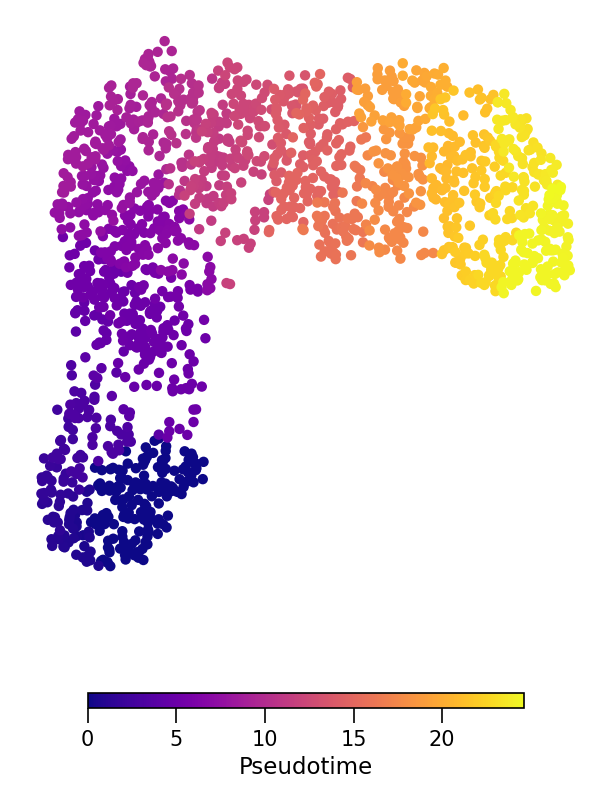

In [40]:
f, ax = plt.subplots(figsize=(5,5))

sc = ax.scatter(anno_sub['UMAP_1'] *-1, 
                anno_sub['UMAP_2'], 
                c=anno_sub['pseudotime'], 
                s=25, 
                cmap='plasma', 
                linewidth=0, 
                edgecolor='k'
)
plt.axis('off')

axins = inset_axes(ax,
                   width="50%",  
                   height="2.5%",
                   loc='lower left',
                   bbox_to_anchor=(.125, -.2, 1.5, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0,
                   )
cbar = f.colorbar(sc, ax=ax, cax=axins, orientation='horizontal', pad=.06)
cbar.ax.set_xlabel('Pseudotime', fontsize=11, labelpad=3)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')

_____

In [29]:
chrom = 'X'

In [30]:
incl_idx = oe_dam_cas[list(oe_dam_cas)[0]][chrom] > .101

incl_idx.size, incl_idx.sum()

(1711, 1511)

In [31]:
thrs = 1.5

In [32]:
states = {0:'No X-inactivation',1:'Undertermined',2:'CAST_EiJ inactivated',3:'129S1_SvImJ inactivated'}

states

{0: 'No X-inactivation',
 1: 'Undertermined',
 2: 'CAST_EiJ inactivated',
 3: '129S1_SvImJ inactivated'}

In [33]:
bcs, state = list(), list()
for i,g in enumerate(bc_dict):
    X = np.mean([fftconvolve(oe_chic_cas[bc][chrom][incl_idx], W, mode='same') for bc in bc_dict[g]], axis=1)
    y = np.mean([fftconvolve(oe_chic_129[bc][chrom][incl_idx], W, mode='same') for bc in bc_dict[g]], axis=1)
    
    idx_act = (X < thrs) & (y < thrs)
    idx_un = (X > thrs) & (y > thrs)
    idx_cas = (X > thrs) & (y < thrs)
    idx_129 = (y > thrs) & (X < thrs)
    
    idx = np.concatenate((idx_act.reshape(idx_act.shape[0],1), idx_un.reshape(idx_un.shape[0],1), 
                          idx_cas.reshape(idx_cas.shape[0],1), idx_129.reshape(idx_129.shape[0],1)), axis=1)
    
    bcs.append(bc_dict[g])
    state.append(idx)
    
bcs, state = np.hstack(bcs), np.vstack(state)

bcs.shape, state.sum(0)

((1656,), array([994,  20, 169, 473]))

In [34]:
#make sure `bcs` has same order as `anno_sub.index`
d = dict(zip(bcs, range(bcs.size)))
sort_idx = [d[bc] for bc in anno_sub.index]

bcs =  bcs[sort_idx]
state = state[sort_idx]

____

In [35]:
dam3d = np.array([[fftconvolve(oe_dam_cas[bc][chrom], W, mode='same'),
                   fftconvolve(oe_dam_129[bc][chrom], W, mode='same')] 
                  for bc in bcs]
)
chic3d = np.array([[fftconvolve(oe_chic_cas[bc][chrom], W, mode='same'),
                    fftconvolve(oe_chic_129[bc][chrom], W, mode='same')] 
                   for bc in bcs]
)

dam3d.shape, chic3d.shape

((1656, 2, 1711), (1656, 2, 1711))

In [36]:
dam2d = dam3d[:,:,lb1_k27_idx].mean(2)
chic2d = chic3d[:,:,lb1_k27_idx].mean(2)

dam2d.shape, chic2d.shape

((1656, 2), (1656, 2))

In [37]:
argsort2d = np.argsort(chic2d, axis=1)

argsort2d.shape

(1656, 2)

____

Text(0, 0.5, 'Xi( H3K27me3 )')

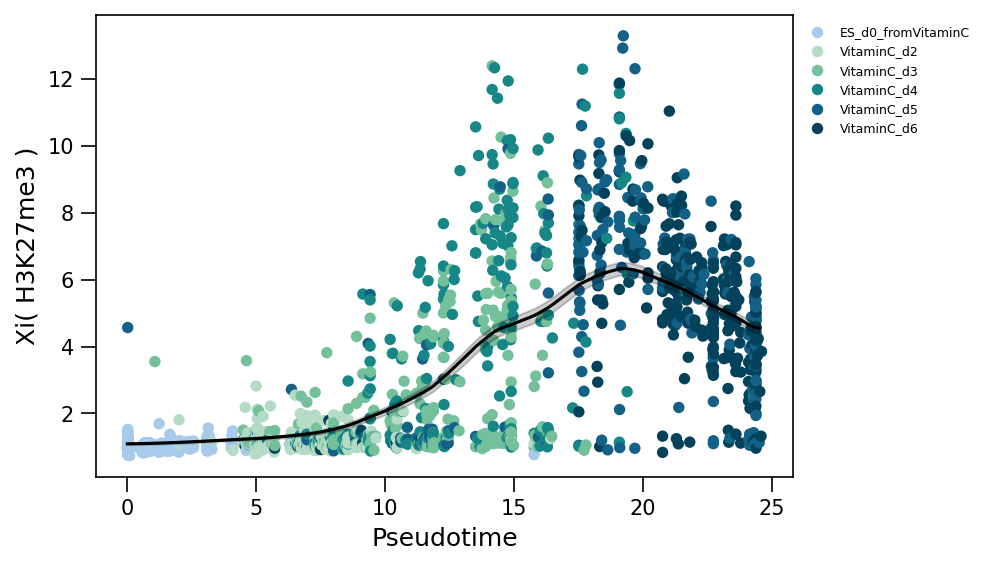

In [39]:
y = np.take_along_axis(chic2d, argsort2d, axis=1)[:,1]
xhat, yhat, yhat_sem = sccu.RNR(anno_sub['pseudotime'], y, _RADIUS=2, step=.1)

f, ax = plt.subplots(figsize=(6,4)) 

sns.scatterplot(x=anno_sub['pseudotime'], 
                y=y, 
                hue=anno_sub['cell_type'], 
                hue_order=np.unique(anno_sub['cell_type']), 
                palette=[coldict[cell_type] for cell_type in np.unique(anno_sub['cell_type'])],
                s=30, 
                lw=0, 
)
ax.plot(xhat, yhat, color='k')
ax.fill_between(xhat, (yhat - yhat_sem), (yhat + yhat_sem), color='k', alpha=.2)

ax.legend(bbox_to_anchor=(1,1), prop={'size':6}, frameon=False)
ax.set_xlabel('Pseudotime', fontsize=12)
ax.set_ylabel('Xi( H3K27me3 )', fontsize=12)

Text(0, 0.5, 'Xi( Dam-Lmnb1 )')

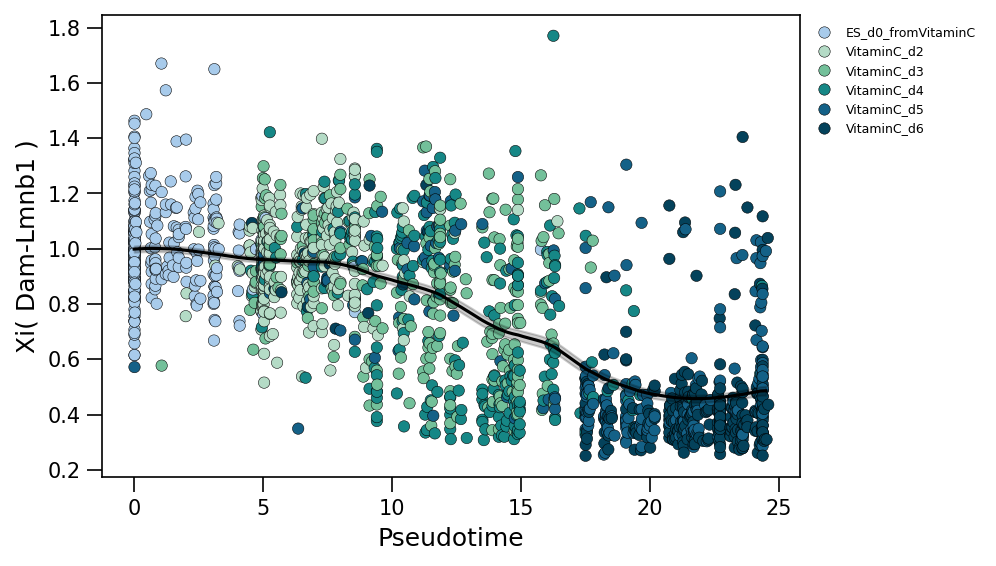

In [46]:
y = np.take_along_axis(dam2d, argsort2d, axis=1)[:,1]
xhat, yhat, yhat_sem = sccu.RNR(anno_sub['pseudotime'], y, _RADIUS=2, step=.1)

f, ax = plt.subplots(figsize=(6,4)) 

sns.scatterplot(x=anno_sub['pseudotime'], 
                y=y, 
                hue=anno_sub['cell_type'], 
                hue_order=np.unique(anno_sub['cell_type']), 
                palette=[coldict[cell_type] for cell_type in np.unique(anno_sub['cell_type'])],
                s=30, 
                linewidth=.25, 
                edgecolor='k'
)
ax.plot(xhat, yhat, color='k')
ax.fill_between(xhat, (yhat - yhat_sem), (yhat + yhat_sem), color='k', alpha=.2)

ax.legend(bbox_to_anchor=(1,1), prop={'size':6}, frameon=False)
ax.set_xlabel('Pseudotime', fontsize=12)
ax.set_ylabel('Xi( Dam-Lmnb1 )', fontsize=12)

____

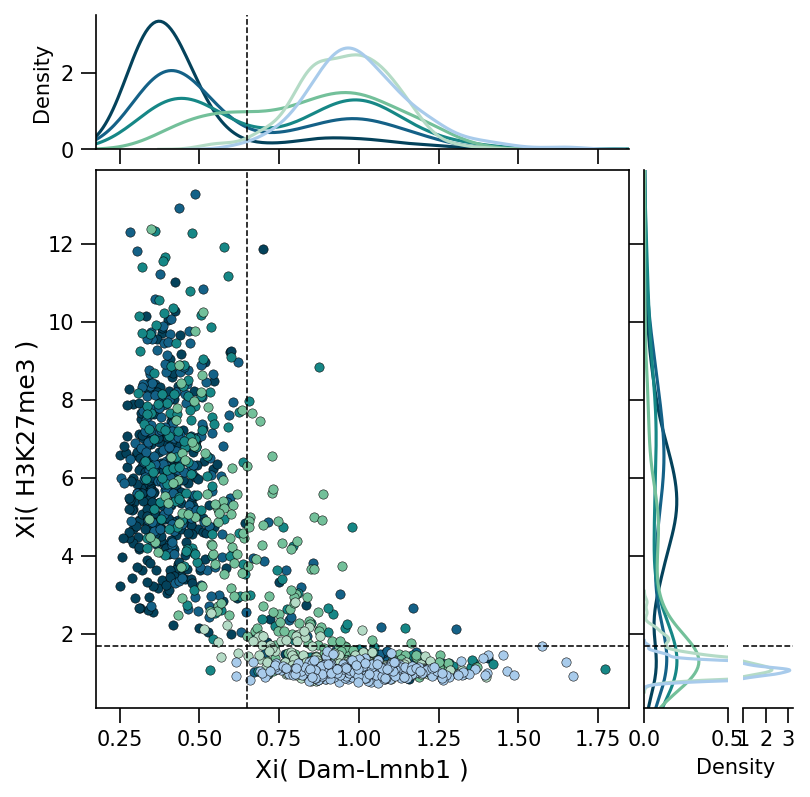

In [57]:
X = np.take_along_axis(dam2d, argsort2d, axis=1)[:,1]
y = np.take_along_axis(chic2d, argsort2d, axis=1)[:,1]

f, ax = plt.subplots(2, 3, figsize=(6,6), gridspec_kw={'height_ratios':[.2,.8],
                                                       'width_ratios':[.8,.125,.075],
                                                       'hspace':.06,
                                                       'wspace':.07}, 
)

for cell_type in np.unique(anno_sub['cell_type'])[::-1]:
        idx = anno_sub['cell_type'] == cell_type
        sns.scatterplot(x=X[idx], 
                        y=y[idx], 
                        color=coldict[cell_type],
                        s=20, 
                        linewidth=.25, 
                        edgecolor='k',
                        label=cell_type,
                        ax=ax[1,0]
        )
sns.kdeplot(x=X, 
            hue=anno_sub['cell_type'], 
            hue_order=np.unique(anno_sub['cell_type']),
            palette=[coldict[cell_type] for cell_type in np.unique(anno_sub['cell_type'])], 
            common_norm=False,
            ax=ax[0,0]
)
sns.kdeplot(y=y, 
            hue=anno_sub['cell_type'], 
            hue_order=np.unique(anno_sub['cell_type']), 
            palette=[coldict[cell_type] for cell_type in np.unique(anno_sub['cell_type'])],
            common_norm=False,
            ax=ax[1,1]
)
sns.kdeplot(y=y, 
            hue=anno_sub['cell_type'], 
            hue_order=np.unique(anno_sub['cell_type']), 
            palette=[coldict[cell_type] for cell_type in np.unique(anno_sub['cell_type'])],
            common_norm=False,
            ax=ax[1,2]
)

ax[1,0].set_xlabel('Xi( Dam-Lmnb1 )', fontsize=12)
ax[1,0].set_ylabel('Xi( H3K27me3 )', fontsize=12)

ax[0,1].remove()
ax[0,2].remove()

ax[0,0].set_xlim(ax[1,0].get_xlim())
ax[1,1].set_ylim(ax[1,0].get_ylim())
ax[1,2].set_ylim(ax[1,0].get_ylim())
ax[1,1].set_yticklabels([])
ax[1,2].set_yticks([])
ax[0,0].set_xticklabels([])
ax[0,0].get_legend().remove()
ax[1,0].get_legend().remove()
ax[1,1].get_legend().remove()
ax[1,2].get_legend().remove()

ax[0,0].spines[['right','top']].set_visible(False)
ax[1,1].spines[['right','top']].set_visible(False)
ax[1,2].spines[['left','top','right']].set_visible(False)

ax[1,1].set_xlim(0,.5)
ax[1,2].set_xlim(1)

ax[1,1].set_xlabel('Density', x=1.1)
ax[1,2].set_xlabel('')


lb1_thrs = .65
k27_thrs = 1.7
for i in range(ax.shape[0]):
    ax[i,0].axvline(lb1_thrs, color='k', lw=.75, ls='--')
    ax[1,i].axhline(k27_thrs, color='k', lw=.75, ls='--')
ax[1,2].axhline(k27_thrs, color='k', lw=.75, ls='--')

___

In [67]:
smooth_stddev = 350000
w = gaussian(ceil(smooth_stddev / BINSIZE * 6 / 2) * 2 + 1, smooth_stddev / BINSIZE)
w /= w.sum()

In [68]:
dam3d = np.array([[fftconvolve(oe_dam_cas[bc][chrom], w, mode='same'),
                          fftconvolve(oe_dam_129[bc][chrom], w, mode='same')] 
                         for bc in bcs]
)
chic3d = np.array([[fftconvolve(oe_chic_cas[bc][chrom], w, mode='same'),
                           fftconvolve(oe_chic_129[bc][chrom], w, mode='same')] 
                          for bc in bcs]
)

dam3d.shape, chic3d.shape

((1656, 2, 1711), (1656, 2, 1711))

In [70]:
X = np.log2(np.take_along_axis(dam3d, np.atleast_3d(argsort2d), axis=1)[:,1,:])
y = np.log2(np.take_along_axis(chic3d, np.atleast_3d(argsort2d), axis=1)[:,1,:])

X.shape, y.shape

((1656, 1711), (1656, 1711))

Text(0.5, 1.0, 'Xi')

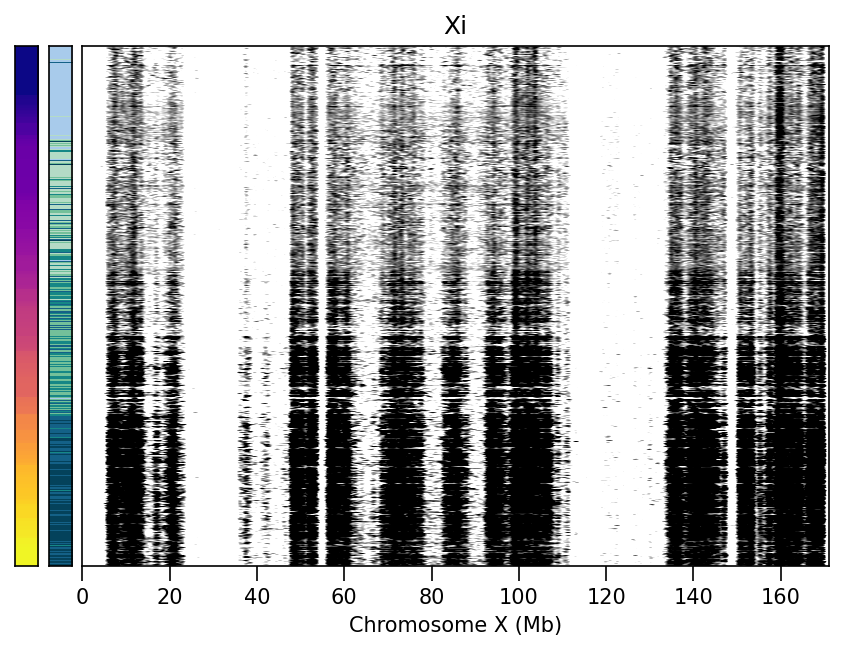

In [71]:
xaxis = np.arange(0,X.shape[1]*BINSIZE,BINSIZE) / 1e6

f, ax = plt.subplots(1, 3, figsize=(7,4.5), gridspec_kw={'width_ratios':[.03,.03,.97],'wspace':.04})

ax[0].pcolorfast(anno_sub['pseudotime'].values.reshape(-1,1)[::-1], 
                 cmap='plasma')

d = dict(zip(np.unique(anno_sub['cell_type']), range(6)))
ax[1].pcolorfast(np.array([d[k] for k in anno_sub['cell_type']])[::-1].reshape(-1,1), 
                 cmap=cmap.from_list('cbar',[coldict[k] for k in d])
)

ax[2].imshow(y, 
             aspect='auto', 
             cmap='binary', 
             vmin=-1, 
             vmax=1, 
             extent=np.hstack([xaxis[[0,-1]], X.shape[0], 0])
)

ax[2].set_xlabel('Chromosome %s (Mb)' %chrom)

for i in (0,1):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
ax[2].set_yticks([])
ax[2].set_title('Xi')

[]

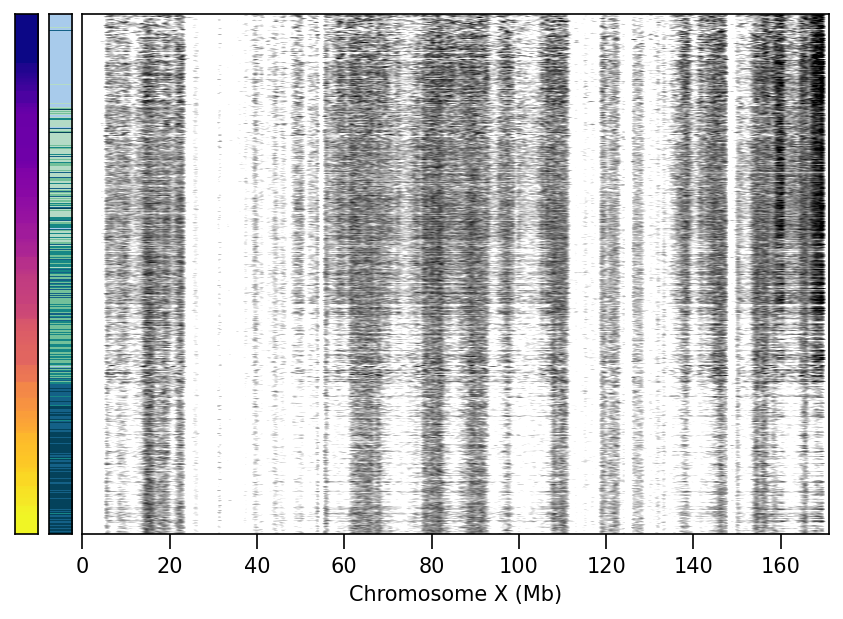

In [72]:
xaxis = np.arange(0,X.shape[1]*BINSIZE,BINSIZE) / 1e6

f, ax = plt.subplots(1, 3, figsize=(7,4.5), gridspec_kw={'width_ratios':[.03,.03,.97],'wspace':.04})

ax[0].pcolorfast(anno_sub['pseudotime'].values.reshape(-1,1)[::-1], 
                 cmap='plasma')

d = dict(zip(np.unique(anno_sub['cell_type']), range(6)))
ax[1].pcolorfast(np.array([d[k] for k in anno_sub['cell_type']])[::-1].reshape(-1,1), 
                 cmap=cmap.from_list('cbar',[coldict[k] for k in d])
)

ax[2].imshow(X, 
             aspect='auto', 
             cmap='binary', 
             vmin=-1.5, 
             vmax=1.5, 
             extent=np.hstack([xaxis[[0,-1]], X.shape[0], 0])
)

ax[2].set_xlabel('Chromosome %s (Mb)' %chrom)

for i in (0,1):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
ax[2].set_yticks([])

____

In [75]:
#Xa: ``[:,0,:]`` Xi: ``[:,1:,]``
X = (np.take_along_axis(dam3d, np.atleast_3d(argsort2d), axis=1)[:,1,:] > 1).astype(int)
y = (np.take_along_axis(chic3d, np.atleast_3d(argsort2d), axis=1)[:,1,:] > 1.7).astype(int)

Z = X + y
Z[y == 1] += 1
Z = Z[::-1]

Z.shape

(1656, 1711)

(5.0, 25.0)

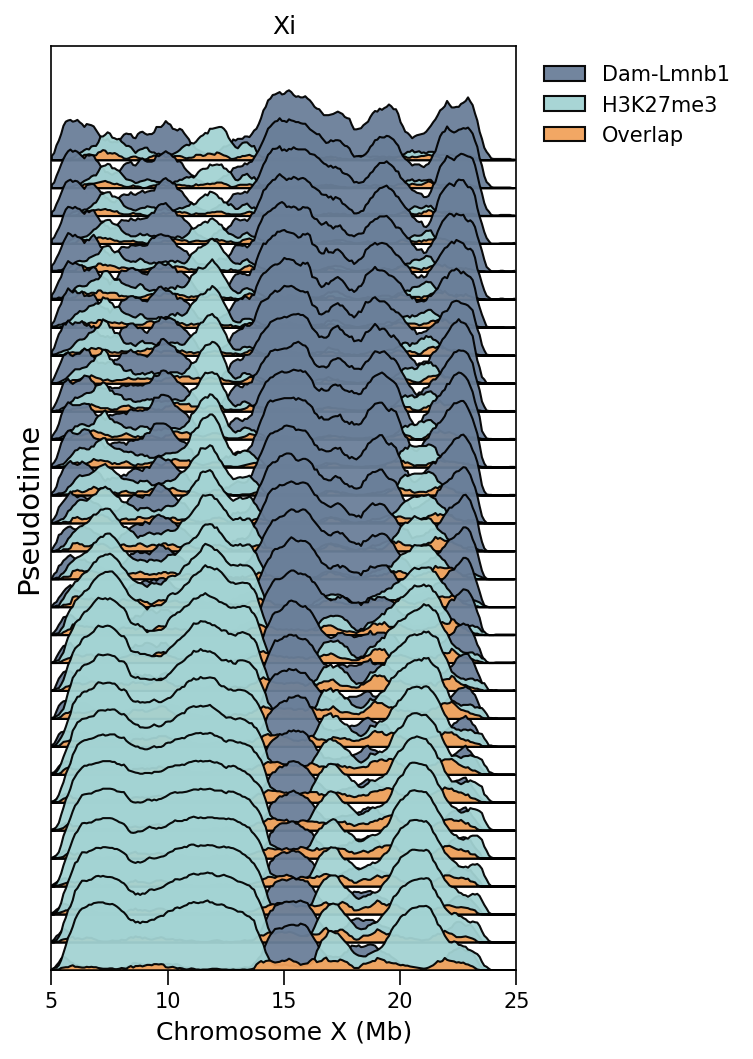

In [80]:
s = 50
e = 250

xaxis = (np.arange(s*BINSIZE,e*BINSIZE,BINSIZE) / 1e6)

window_size = 200
step_size = 50
window_max = Z.shape[0] - window_size
_range = range(0,window_max,step_size)

f, ax = plt.subplots(figsize=(4,8))

dist = .4
for index,i in enumerate(_range):
    
    _x = (Z[i:i+window_size, s:e] == 1).mean(0)
    _y = (Z[i:i+window_size, s:e] == 2).mean(0)
    _z = (Z[i:i+window_size, s:e] == 3).mean(0)
    
    #scale to same range
    _min = np.r_[_x, _y, _z].min()
    _max = np.r_[_x, _y, _z].max()
    
    zorder = len(_range)-index
    for ploti,v in enumerate((_x,_y,_z)):
        v_scale = ((v - _min) / (_max - _min)) + dist*index
        ax.fill_between(xaxis, 
                        dist*index,
                        v_scale, 
                        color=['#6A7F99','#A3D3D3','#F2A25C'][ploti], 
                        label=['Dam-Lmnb1','H3K27me3','Overlap'][ploti],
                        edgecolor='black', 
                        zorder=zorder, 
                        alpha=.95
        )

legend_without_duplicate_labels(ax, bbox_to_anchor=(1.5,1), frameon=False)
ax.set_ylabel('Pseudotime', fontsize=14)
ax.set_xticks(np.arange((s*BINSIZE)/1e6,((e*BINSIZE)/1e6)+.1,5))
ax.set_ylim(0)
ax.set_yticks([])
ax.set_xlabel('Chromosome %s (Mb)' %chrom, fontsize=12)
ax.set_title('Xi')
ax.set_xlim(5,25)

_____

Text(0.5, 0, 'Time')

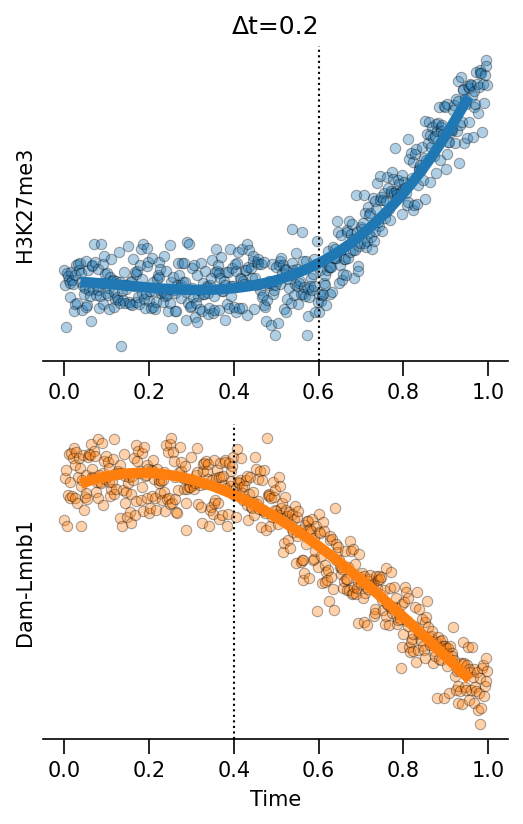

In [85]:
n_obs = 500
xaxis = np.arange(0,1,1/n_obs)

f, ax = plt.subplots(2, 1, figsize=(4,6))

switch = .6
t_normal_up = simulate_dynamics(n_obs, switch, direction=1, noise_level=.1, seed=3)
X_line, y_line, ci = sccu.polynomial_regression(xaxis, t_normal_up, 3, pad=-.05)

sns.scatterplot(x=xaxis, 
                y=t_normal_up, 
                linewidth=.5,
                alpha=.35,
                edgecolor='k',
                s=25,
                ax=ax[0]
)

ax[0].plot(X_line, y_line, lw=5)
ax[0].axvline(switch, color='k', lw=1, ls=':')
ax[0].set_ylabel('H3K27me3')

switch = .4
t_normal_down = simulate_dynamics(n_obs, switch, direction=-1, noise_level=.1, seed=0)
X_line, y_line, ci = sccu.polynomial_regression(xaxis, t_normal_down, 3, pad=-.05)

sns.scatterplot(x=xaxis, 
                y=t_normal_down, 
                linewidth=.5,
                alpha=.35,
                color=COLORS[1],
                edgecolor='k',
                s=25,
                ax=ax[1]
)

ax[1].plot(X_line, y_line, color=COLORS[1], lw=5)
ax[1].axvline(switch, color='k', lw=1, ls=':')
ax[1].set_ylabel('Dam-Lmnb1')

for i in range(ax.size):
    ax[i].spines[['right','left','top']].set_visible(False)
    #ax[i].set_xticks([])
    ax[i].set_yticks([])
    
ax[0].set_title('\u0394t=0.2')
ax[-1].set_xlabel('Time')

Text(0, 0.5, 'H3K27me3')

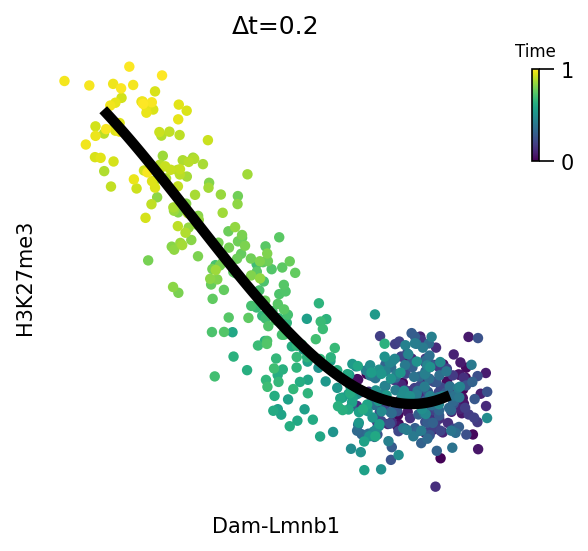

In [86]:
f, ax = plt.subplots(figsize=(4,4))

sct = ax.scatter(t_normal_down, 
           t_normal_up,
           c=xaxis,
           linewidth=0,
           edgecolor='k',
           s=25
)


X_line, y_line, ci = sccu.polynomial_regression(t_normal_down, t_normal_up, 3, pad=-.1)
ax.plot(X_line, y_line, color='k', lw=5)

ax.spines[['right','left','top','bottom']].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

axins = inset_axes(ax,
   width="1%",  # width = 5% of parent_bbox width
   height="20%",  # height : 50%
   loc='lower left',
   bbox_to_anchor=(1.05, .75, 1.5, 1),
   bbox_transform=ax.transAxes,
   borderpad=0,
   )
cbar = f.colorbar(sct, ax=ax, cax=axins, pad=.06, ticks=[0,xaxis.max()])
cbar.ax.set_title('Time', fontsize=8)
cbar.ax.set_yticklabels([0,1])
ax.set_title('\u0394t=0.2')

ax.set_xlabel('Dam-Lmnb1')
ax.set_ylabel('H3K27me3')

Text(0, 0.5, 'H3K27me3')

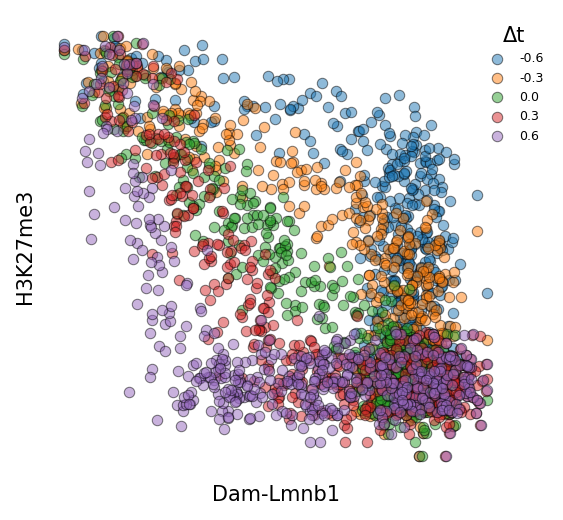

In [89]:
f, ax = plt.subplots(figsize=(4,4),)

i = 0
for s0,s1 in zip([.2,.35,.5,.65,.8],[.2,.35,.5,.65,.8][::-1]):
    t_normal_up = simulate_dynamics(n_obs, s0, direction=1, noise_level=.075, seed=3)
    t_normal_down = simulate_dynamics(n_obs, s1, direction=-1, noise_level=.075, seed=0)

    ax.scatter(t_normal_down, 
               t_normal_up,
               color=COLORS[i],
               linewidth=.5,
               edgecolor='k',
               alpha=.5,
               s=25, 
               label=round(s0-s1,1)
    )
    i += 1
    
ax.legend(prop={'size':6}, title='\u0394t', bbox_to_anchor=(1.1,1), frameon=False)

ax.spines[['right','left','top','bottom']].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

ax.set_xlabel('Dam-Lmnb1')
ax.set_ylabel('H3K27me3')

____

# Dam-K27me3 & Lmnb1

In [102]:
construct = 'Dam-scFv-K27me3'
antibody = 'LmnB1'
cell_type = 'VitaminC'

In [103]:
anno_sub = anno.loc[(anno.index.isin(list(oe_dam_cas)) & 
                     anno.index.isin(list(oe_dam_129)) & 
                     anno.index.isin(list(oe_chic_cas)) & 
                     anno.index.isin(list(oe_chic_129)))
]

anno_sub.shape

(7084, 17)

In [104]:
anno_sub = anno_sub[(anno_sub['construct'] == construct) &
                    (anno_sub['antibody'] == antibody) & 
                    (anno_sub['cell_type'].str.contains(cell_type) | anno_sub['cell_type'].str.contains('ES'))]

anno_sub.shape

(1919, 17)

In [105]:
gb = anno_sub.groupby(['construct','antibody','cell_type'])

gb.size().to_frame('Cells')

Cells
construct       antibody cell_type         
Dam-scFv-K27me3 LmnB1    ES_d0          153
                         VitaminC_d2    148
                         VitaminC_d3   1157
                         VitaminC_d4    153
                         VitaminC_d5    159
                         VitaminC_d6    149

In [106]:
np.random.seed(4)

n = 159
_bcs = np.random.choice(anno_sub[anno_sub['cell_type'] == 'VitaminC_d3'].index, n, replace=False)

anno_sub = pd.DataFrame(anno_sub[anno_sub.index.isin(_bcs) | (anno_sub['cell_type'] != 'VitaminC_d3')])

anno_sub.shape

(921, 17)

In [107]:
gb = anno_sub.groupby(['construct','antibody','cell_type'])

gb.size().to_frame('Cells')

Cells
construct       antibody cell_type         
Dam-scFv-K27me3 LmnB1    ES_d0          153
                         VitaminC_d2    148
                         VitaminC_d3    159
                         VitaminC_d4    153
                         VitaminC_d5    159
                         VitaminC_d6    149

In [108]:
bc_dict = gb.groups

list(bc_dict), len(bc_dict)

([('Dam-scFv-K27me3', 'LmnB1', 'ES_d0'),
  ('Dam-scFv-K27me3', 'LmnB1', 'VitaminC_d2'),
  ('Dam-scFv-K27me3', 'LmnB1', 'VitaminC_d3'),
  ('Dam-scFv-K27me3', 'LmnB1', 'VitaminC_d4'),
  ('Dam-scFv-K27me3', 'LmnB1', 'VitaminC_d5'),
  ('Dam-scFv-K27me3', 'LmnB1', 'VitaminC_d6')],
 6)

____

In [115]:
chrom = 'X'

In [116]:
thrs = .95

In [117]:
states = {0:'No X-inactivation',1:'Undertermined',2:'CAST_EiJ inactivated',3:'129S1_SvImJ inactivated'}

states

{0: 'No X-inactivation',
 1: 'Undertermined',
 2: 'CAST_EiJ inactivated',
 3: '129S1_SvImJ inactivated'}

In [118]:
bcs, state = list(), list()
for i,g in enumerate(bc_dict):
    X = np.mean([fftconvolve(oe_dam_cas[bc][chrom][incl_idx], W, mode='same') for bc in bc_dict[g]], axis=1)
    y = np.mean([fftconvolve(oe_dam_129[bc][chrom][incl_idx], W, mode='same') for bc in bc_dict[g]], axis=1)
    
    idx_act = (X < thrs) & (y < thrs)
    idx_un = (X > thrs) & (y > thrs)
    idx_cas = (X > thrs) & (y < thrs)
    idx_129 = (y > thrs) & (X < thrs)
    
    idx = np.concatenate((idx_act.reshape(idx_act.shape[0],1), idx_un.reshape(idx_un.shape[0],1), 
                          idx_cas.reshape(idx_cas.shape[0],1), idx_129.reshape(idx_129.shape[0],1)), axis=1)
    
    bcs.append(bc_dict[g])
    state.append(idx)
    
bcs, state = np.hstack(bcs), np.vstack(state)

bcs.shape, state.sum(0)

((921,), array([528,  28, 129, 236]))

In [119]:
#make sure ``bcs`` has same order as ``anno_sub.index``
d = dict(zip(bcs, range(bcs.size)))
sort_idx = [d[bc] for bc in anno_sub.index]

bcs =  bcs[sort_idx]
state = state[sort_idx]

____

In [120]:
smooth_stddev = 350000
w = gaussian(ceil(smooth_stddev / BINSIZE * 6 / 2) * 2 + 1, smooth_stddev / BINSIZE)
w /= w.sum()

In [121]:
dam3d = np.array([[fftconvolve(oe_dam_cas[bc][chrom], w, mode='same'),
                   fftconvolve(oe_dam_129[bc][chrom], w, mode='same')] 
                  for bc in bcs]
)
chic3d = np.array([[fftconvolve(oe_chic_cas[bc][chrom], w, mode='same'),
                    fftconvolve(oe_chic_129[bc][chrom], w, mode='same')] 
                   for bc in bcs]
)

dam3d.shape, chic3d.shape

((921, 2, 1711), (921, 2, 1711))

In [122]:
dam2d = dam3d[:,:,lb1_k27_idx].mean(2)
chic2d = chic3d[:,:,lb1_k27_idx].mean(2)

dam2d.shape, chic2d.shape

((921, 2), (921, 2))

In [123]:
argsort2d = np.argsort(dam2d, axis=1)

argsort2d.shape

(921, 2)

____

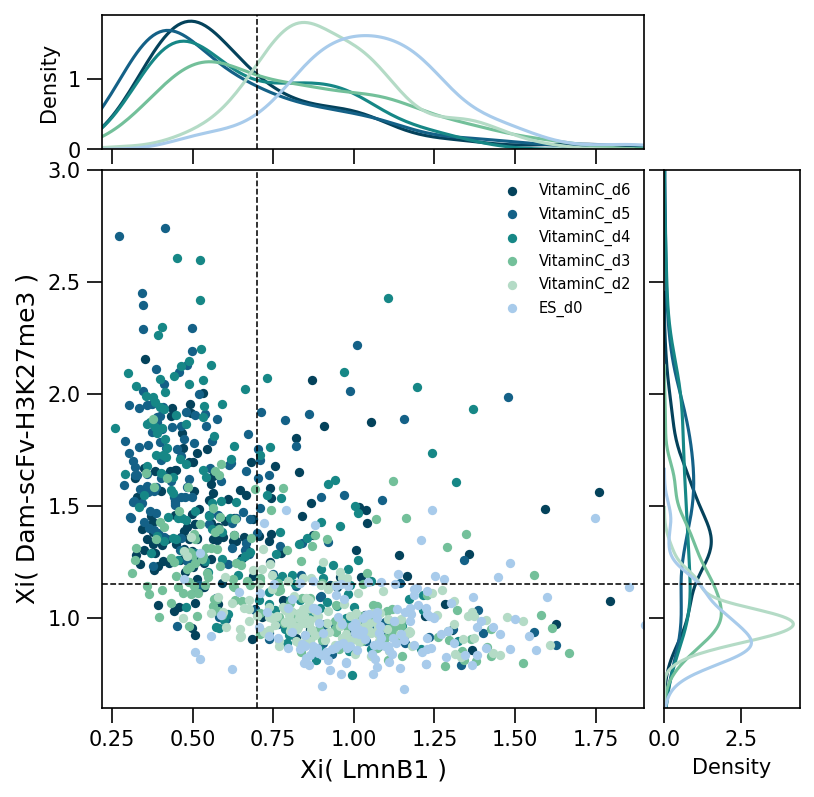

In [126]:
X = np.take_along_axis(chic2d, argsort2d, axis=1)[:,1]
y = np.take_along_axis(dam2d, argsort2d, axis=1)[:,1]

f, ax = plt.subplots(2, 2, figsize=(6,6), gridspec_kw={'height_ratios':[.2,.8],
                                                       'width_ratios':[.8,.2],
                                                       'hspace':.06,
                                                       'wspace':.06},
)

for cell_type in np.unique(anno_sub['cell_type'])[::-1]:
        idx = anno_sub['cell_type'] == cell_type
        sns.scatterplot(x=X[idx], 
                        y=y[idx], 
                        color=coldict[cell_type],
                        s=20, 
                        linewidth=0, 
                        label=cell_type,
                        ax=ax[1,0]
        )
sns.kdeplot(x=X, 
            hue=anno_sub['cell_type'], 
            hue_order=np.unique(anno_sub['cell_type']),
            palette=[coldict[cell_type] for cell_type in np.unique(anno_sub['cell_type'])], 
            common_norm=False,
            ax=ax[0,0]
)

sns.kdeplot(y=y, 
            hue=anno_sub['cell_type'], 
            hue_order=np.unique(anno_sub['cell_type']), 
            palette=[coldict[cell_type] for cell_type in np.unique(anno_sub['cell_type'])],
            common_norm=False,
            ax=ax[1,1]
)

ax[1,0].set_xlim(.22,1.9)
ax[1,0].set_ylim(.6,3)

ax[1,0].set_xlabel('Xi( LmnB1 )', fontsize=12)
ax[1,0].set_ylabel('Xi( Dam-scFv-H3K27me3 )', fontsize=12)
ax[1,0].legend(prop={'size':7}, frameon=False)

ax[0,1].remove()
ax[0,0].set_xlim(ax[1,0].get_xlim())
ax[1,1].set_ylim(ax[1,0].get_ylim())
ax[1,1].set_yticklabels([])
ax[0,0].set_xticklabels([])
ax[0,0].get_legend().remove()
ax[1,1].get_legend().remove()

lb1_thrs = .7
k27_thrs = 1.15
for i in range(ax.shape[0]):
    ax[i,0].axvline(lb1_thrs, color='k', lw=.75, ls='--')
    ax[1,i].axhline(k27_thrs, color='k', lw=.75, ls='--')

___

### Dam-LMNB1 vs. H2AK119Ub

In [49]:
construct = 'Dam-LmnB1'
antibody = 'H2AK119Ub'
cell_type = 'VitaminC'

In [50]:
anno_sub = anno.loc[(anno.index.isin(list(oe_dam_cas)) & 
                     anno.index.isin(list(oe_dam_129)) & 
                     anno.index.isin(list(oe_chic_cas)) & 
                     anno.index.isin(list(oe_chic_129)))
]

anno_sub.shape

(8297, 18)

In [51]:
anno_sub = anno_sub[(anno_sub['construct'] == construct) &
                    (anno_sub['antibody'] == antibody) & 
                    (anno_sub['cell_type'].str.contains(cell_type) | anno_sub['cell_type'].str.contains('ES'))]

anno_sub.shape

(1213, 18)

In [52]:
gb = anno_sub.groupby(['construct','antibody','cell_type'])

gb.size().to_frame('Cells')

Cells
construct antibody  cell_type         
Dam-LmnB1 H2AK119Ub ES_d0          215
                    VitaminC_d2    182
                    VitaminC_d3    202
                    VitaminC_d4    207
                    VitaminC_d5    213
                    VitaminC_d6    194

In [53]:
bc_dict = gb.groups

list(bc_dict), len(bc_dict)

([('Dam-LmnB1', 'H2AK119Ub', 'ES_d0'),
  ('Dam-LmnB1', 'H2AK119Ub', 'VitaminC_d2'),
  ('Dam-LmnB1', 'H2AK119Ub', 'VitaminC_d3'),
  ('Dam-LmnB1', 'H2AK119Ub', 'VitaminC_d4'),
  ('Dam-LmnB1', 'H2AK119Ub', 'VitaminC_d5'),
  ('Dam-LmnB1', 'H2AK119Ub', 'VitaminC_d6')],
 6)

____

In [56]:
chrom = 'X'

In [59]:
incl_idx = oe_dam_cas[list(oe_dam_cas)[0]][chrom] > .101

incl_idx.size, incl_idx.sum()

(1711, 1511)

In [60]:
states = {0:'No X-inactivation',1:'Undertermined',2:'CAST_EiJ inactivated',3:'129S1_SvImJ inactivated'}

states

{0: 'No X-inactivation',
 1: 'Undertermined',
 2: 'CAST_EiJ inactivated',
 3: '129S1_SvImJ inactivated'}

In [62]:
thrs = .9

bcs, state = list(), list()
for i,g in enumerate(bc_dict):
    X = np.mean([fftconvolve(oe_chic_cas[bc][chrom][incl_idx], W, mode='same') for bc in bc_dict[g]], axis=1)
    y = np.mean([fftconvolve(oe_chic_129[bc][chrom][incl_idx], W, mode='same') for bc in bc_dict[g]], axis=1)
    
    idx_act = (X < thrs) & (y < thrs)
    idx_un = (X > thrs) & (y > thrs)
    idx_cas = (X > thrs) & (y < thrs)
    idx_129 = (y > thrs) & (X < thrs)
    
    idx = np.concatenate((idx_act.reshape(idx_act.shape[0],1), idx_un.reshape(idx_un.shape[0],1), 
                          idx_cas.reshape(idx_cas.shape[0],1), idx_129.reshape(idx_129.shape[0],1)), axis=1)
    
    bcs.append(bc_dict[g])
    state.append(idx)
    
bcs, state = np.hstack(bcs), np.vstack(state)

bcs.shape, state.sum(0)

((1213,), array([740,  27, 148, 298]))

In [63]:
#make sure ``bcs`` has same order as ``anno_sub.index``
d = dict(zip(bcs, range(bcs.size)))
sort_idx = [d[bc] for bc in anno_sub.index]

bcs =  bcs[sort_idx]
state = state[sort_idx]

___

In [64]:
dam3d = np.array([[fftconvolve(oe_dam_cas[bc][chrom], W, mode='same'),
                   fftconvolve(oe_dam_129[bc][chrom], W, mode='same')] 
                  for bc in bcs]
)
chic3d = np.array([[fftconvolve(oe_chic_cas[bc][chrom], W, mode='same'),
                    fftconvolve(oe_chic_129[bc][chrom], W, mode='same')] 
                   for bc in bcs]
)

dam3d.shape, chic3d.shape

((1213, 2, 1711), (1213, 2, 1711))

In [65]:
dam2d = dam3d[:,:,lb1_k27_idx].mean(2)
chic2d = chic3d[:,:,lb1_k27_idx].mean(2)

dam2d.shape, chic2d.shape

((1213, 2), (1213, 2))

In [66]:
argsort2d = np.argsort(chic2d, axis=1)

argsort2d.shape

(1213, 2)

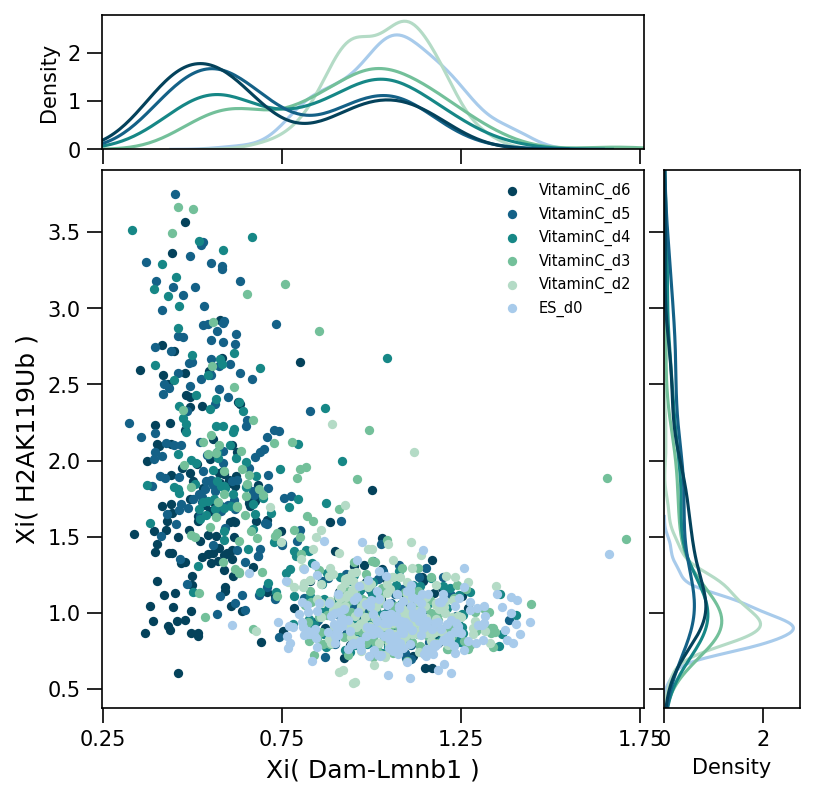

In [67]:
X = np.take_along_axis(dam2d, argsort2d, axis=1)[:,1]
y = np.take_along_axis(chic2d, argsort2d, axis=1)[:,1]

f, ax = plt.subplots(2, 2, figsize=(6,6), gridspec_kw={'height_ratios':[.2,.8],
                                                       'width_ratios':[.8,.2],
                                                       'hspace':.06,
                                                       'wspace':.06}, dpi=150)

for cell_type in np.unique(anno_sub['cell_type'])[::-1]:
        idx = anno_sub['cell_type'] == cell_type
        sns.scatterplot(x=X[idx], 
                        y=y[idx],
                        s=20, 
                        linewidth=0, 
                        edgecolor='k',
                        color=coldict[cell_type],
                        label=cell_type,
                        ax=ax[1,0]
        )
sns.kdeplot(x=X, 
            hue=anno_sub['cell_type'], 
            hue_order=np.unique(anno_sub['cell_type'])[::-1], 
            palette=[coldict[cell_type] for cell_type in np.unique(anno_sub['cell_type'])[::-1]],
            common_norm=False,
            ax=ax[0,0]
)

sns.kdeplot(y=y, 
            hue=anno_sub['cell_type'], 
            hue_order=np.unique(anno_sub['cell_type'])[::-1],
            palette=[coldict[cell_type] for cell_type in np.unique(anno_sub['cell_type'])[::-1]],
            common_norm=False,
            ax=ax[1,1]
)

# ax[1,0].axhline(1.7, lw=1, color='k')
# ax[1,0].axvline(.8, lw=1, color='k')
ax[1,0].set_xticks(np.arange(.25,1.76,.5))
ax[0,0].set_xticks(np.arange(.25,1.76,.5))

ax[1,0].set_xlim(right=1.76)
ax[1,0].set_xlabel('Xi( Dam-Lmnb1 )', fontsize=12)
ax[1,0].set_ylabel('Xi( H2AK119Ub )', fontsize=12)
ax[1,0].legend(prop={'size':7}, frameon=False)

ax[0,1].remove()
ax[0,0].set_xlim(ax[1,0].get_xlim())
ax[1,1].set_ylim(ax[1,0].get_ylim())
ax[1,1].set_yticklabels([])
ax[0,0].set_xticklabels([])
ax[0,0].get_legend().remove()
ax[1,1].get_legend().remove()

____

### Dam-scFv-K27me3 & H2AK119ub

In [68]:
construct = 'Dam-scFv-K27me3'
antibody = 'H2AK119Ub'
cell_type = 'VitaminC'

In [69]:
anno_sub = anno.loc[(anno.index.isin(list(oe_dam_cas)) & 
                     anno.index.isin(list(oe_dam_129)) & 
                     anno.index.isin(list(oe_chic_cas)) & 
                     anno.index.isin(list(oe_chic_129)))
]

anno_sub.shape

(8297, 18)

In [70]:
anno_sub = pd.DataFrame(anno_sub[(anno_sub['construct'] == construct) &
                                 (anno_sub['antibody'] == antibody)]
)

anno_sub.shape

(1404, 18)

In [71]:
gb = anno_sub.groupby(['construct','antibody','cell_type'])

gb.size().to_frame('Cells')

Cells
construct       antibody  cell_type         
Dam-scFv-K27me3 H2AK119Ub ESCs_d0        230
                          VitaminC_d2    228
                          VitaminC_d3    233
                          VitaminC_d4    234
                          VitaminC_d5    240
                          VitaminC_d6    239

In [72]:
bc_dict = gb.groups

list(bc_dict), len(bc_dict)

([('Dam-scFv-K27me3', 'H2AK119Ub', 'ESCs_d0'),
  ('Dam-scFv-K27me3', 'H2AK119Ub', 'VitaminC_d2'),
  ('Dam-scFv-K27me3', 'H2AK119Ub', 'VitaminC_d3'),
  ('Dam-scFv-K27me3', 'H2AK119Ub', 'VitaminC_d4'),
  ('Dam-scFv-K27me3', 'H2AK119Ub', 'VitaminC_d5'),
  ('Dam-scFv-K27me3', 'H2AK119Ub', 'VitaminC_d6')],
 6)

____

In [73]:
chrom = 'X'

In [74]:
incl_idx = oe_dam_cas[list(oe_dam_cas)[0]][chrom] > .101

incl_idx.size, incl_idx.sum()

(1711, 1511)

In [75]:
states = {0:'No X-inactivation',1:'Undertermined',2:'CAST_EiJ inactivated',3:'129S1_SvImJ inactivated'}

states

{0: 'No X-inactivation',
 1: 'Undertermined',
 2: 'CAST_EiJ inactivated',
 3: '129S1_SvImJ inactivated'}

In [77]:
thrs = 1

bcs, state = list(), list()
for i,g in enumerate(bc_dict):
    X = np.mean([fftconvolve(oe_chic_cas[bc][chrom][incl_idx], W, mode='same') for bc in bc_dict[g]], axis=1)
    y = np.mean([fftconvolve(oe_chic_129[bc][chrom][incl_idx], W, mode='same') for bc in bc_dict[g]], axis=1)
    
    idx_act = (X < thrs) & (y < thrs)
    idx_un = (X > thrs) & (y > thrs)
    idx_cas = (X > thrs) & (y < thrs)
    idx_129 = (y > thrs) & (X < thrs)
    
    idx = np.concatenate((idx_act.reshape(idx_act.shape[0],1), idx_un.reshape(idx_un.shape[0],1), 
                          idx_cas.reshape(idx_cas.shape[0],1), idx_129.reshape(idx_129.shape[0],1)), axis=1)
    
    bcs.append(bc_dict[g])
    state.append(idx)
    
bcs, state = np.hstack(bcs), np.vstack(state)

bcs.shape, state.sum(0)

((1404,), array([861,   9, 172, 362]))

In [78]:
#make sure ``bcs`` has same order as ``anno_sub.index``
d = dict(zip(bcs, range(bcs.size)))
sort_idx = [d[bc] for bc in anno_sub.index]

bcs =  bcs[sort_idx]
state = state[sort_idx]

____

In [79]:
smooth_stddev = 150000
w = gaussian(ceil(smooth_stddev / BINSIZE * 6 / 2) * 2 + 1, smooth_stddev / BINSIZE)
w /= w.sum()

In [80]:
dam3d = np.array([[fftconvolve(oe_dam_cas[bc][chrom], w, mode='same'),
                   fftconvolve(oe_dam_129[bc][chrom], w, mode='same')] 
                  for bc in bcs]
)
chic3d = np.array([[fftconvolve(oe_chic_cas[bc][chrom], w, mode='same'),
                    fftconvolve(oe_chic_129[bc][chrom], w, mode='same')] 
                   for bc in bcs]
)

dam3d.shape, chic3d.shape

((1404, 2, 1711), (1404, 2, 1711))

In [81]:
dam2d = dam3d[:,:,lb1_k27_idx].mean(2)
chic2d = chic3d[:,:,lb1_k27_idx].mean(2)

dam2d.shape, chic2d.shape

((1404, 2), (1404, 2))

In [82]:
argsort2d = np.argsort(chic2d, axis=1)

argsort2d.shape

(1404, 2)

___

(0.0, 1.5)

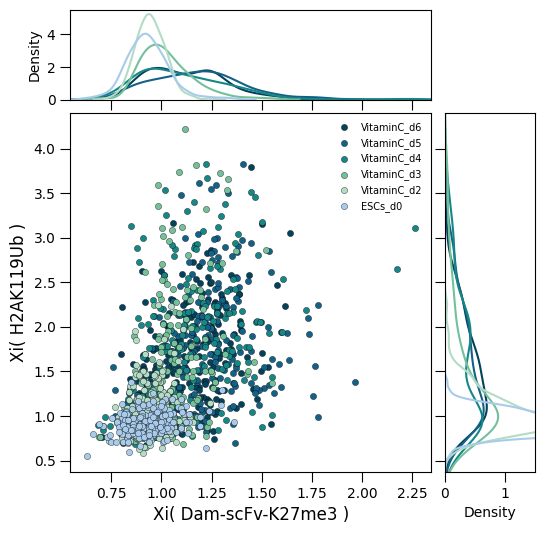

In [83]:
X = np.take_along_axis(dam2d, argsort2d, axis=1)[:,1]
y = np.take_along_axis(chic2d, argsort2d, axis=1)[:,1]

f, ax = plt.subplots(2, 2, figsize=(6,6), gridspec_kw={'height_ratios':[.2,.8],
                                                       'width_ratios':[.8,.2],
                                                       'hspace':.06,
                                                       'wspace':.06}, dpi=100)

for cell_type in np.unique(anno_sub['cell_type'])[::-1]:
        idx = anno_sub['cell_type'] == cell_type
        sns.scatterplot(x=X[idx], 
                        y=y[idx], 
                        color=coldict[cell_type],
                        s=20, 
                        linewidth=.25, 
                        edgecolor='k',
                        label=cell_type,
                        ax=ax[1,0]
        )
sns.kdeplot(x=X, 
            hue=anno_sub['cell_type'], 
            hue_order=np.unique(anno_sub['cell_type']),
            palette=[coldict[cell_type] for cell_type in np.unique(anno_sub['cell_type'])], 
            common_norm=False,
            ax=ax[0,0]
)

sns.kdeplot(y=y, 
            hue=anno_sub['cell_type'], 
            hue_order=np.unique(anno_sub['cell_type']), 
            palette=[coldict[cell_type] for cell_type in np.unique(anno_sub['cell_type'])],
            common_norm=False,
            ax=ax[1,1]
)

# ax[1,0].axhline(1.7, lw=1, color='k')
# ax[1,0].axvline(.8, lw=1, color='k')

ax[1,0].set_xlabel(f"Xi( {construct} )", fontsize=12)
ax[1,0].set_ylabel(f"Xi( {antibody} )", fontsize=12)
ax[1,0].legend(prop={'size':7}, frameon=False)

ax[0,1].remove()
ax[0,0].set_xlim(ax[1,0].get_xlim())
ax[1,1].set_ylim(ax[1,0].get_ylim())
ax[1,1].set_yticklabels([])
ax[0,0].set_xticklabels([])
ax[0,0].get_legend().remove()
ax[1,1].get_legend().remove()
ax[1,1].set_xlim(0,1.5)

Text(0, 0.5, 'Xi(Dam-scFv-K27me3)')

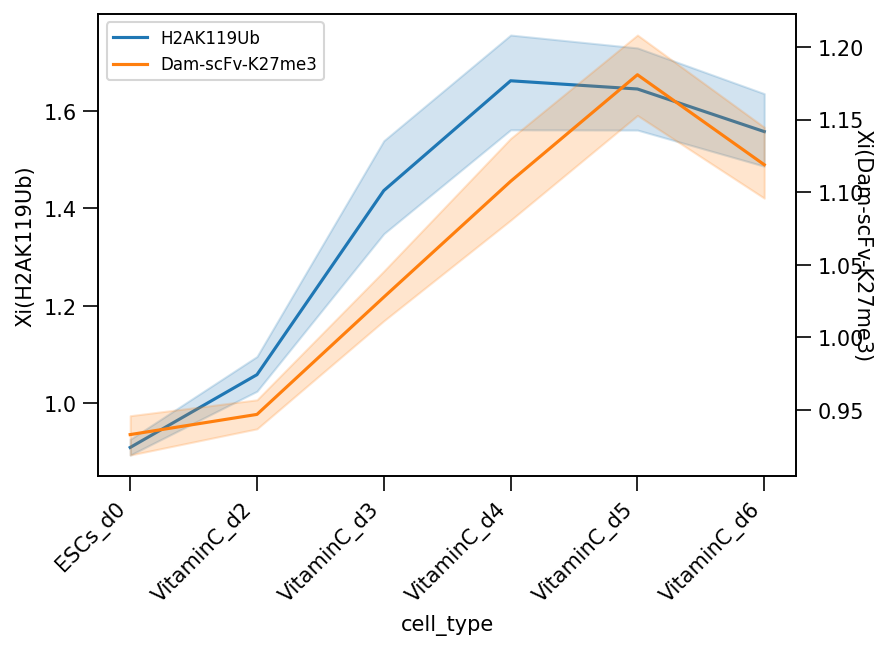

In [85]:
X = np.take_along_axis(dam2d, argsort2d, axis=1)[:,1]
y = np.take_along_axis(chic2d, argsort2d, axis=1)[:,1]

f, ax = plt.subplots(figsize=(6,4))

sns.lineplot(x=anno_sub['cell_type'], 
              y=y, 
              color=COLORS[0],
              label=antibody,
              legend=False,
              ax=ax
)

ax_r = ax.twinx()
sns.lineplot(x=anno_sub['cell_type'], 
              y=X, 
              color=COLORS[1],
              label=construct,
              legend=False,
              ax=ax_r,
)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax_r.get_legend_handles_labels()
ax_r.legend(lines + lines2, labels + labels2, prop={'size':8})

ax.set_xticks(range(np.unique(anno_sub['cell_type']).size),np.unique(anno_sub['cell_type']), rotation=45, ha='right')
ax.set_ylabel(f"Xi({antibody})")
ax_r.set_ylabel(f"Xi({construct})", rotation=-90)

_____

### Dam&T - Dam-LmnB1 

In [87]:
_anno = pd.read_csv('/Users/prullens/Documents/projects/DamnChIC/experiments/VAN10206/VAN10206_SSC_seqrun_anno_XCI_GSK126_DMSO.tsv', sep='\t')
_anno['limsid'] = 'VAN10206'
_anno.index = ['%s.index%02d.%03d' %(limsid,i,bc) for limsid,i,bc in _anno[['limsid','indexnr','barcodenr']].values]

_anno.shape

(4224, 13)

In [88]:
gtf = pd.read_csv('/Users/prullens/metadata/mm10.Mus_musculus.GRCm38.89.with_ERCC.gff.tsv.gz', sep='\t', index_col='gene_name')

gtf.shape

(52004, 7)

In [93]:
hdf5_list = [DAMCASFMT %(limsid,limsid,i,bc) 
             for limsid,i,bc in _anno.loc[_anno['prep'] == 'DamT',['limsid','indexnr','barcodenr']].values
]
hdf5_list = [fn for fn in hdf5_list if os.path.isfile(fn)]

len(hdf5_list)

4223

In [95]:
oe_dam_cas, depths = scct.compute_oe(hdf5_list, 
                                     BINSIZE, 
                                     CHROMSIZES, 
                                     depth_thrs=200, 
                                     expected=EXPECTED %BINSIZE, 
                                     blacklist=BLACKLIST, 
                                     chroms=CHROMS,
)
_anno['dam_counts_cas'] = [depths[bc] if bc in depths else 0 for bc in _anno.index]

len(oe_dam_cas)

  0%|          | 0/4223 [00:00<?, ?it/s]

2800

In [97]:
hdf5_list = [DAM129FMT %(limsid,limsid,i,bc) 
             for limsid,i,bc in _anno.loc[_anno['prep'] == 'DamT',['limsid','indexnr','barcodenr']].values
]
hdf5_list = [fn for fn in hdf5_list if os.path.isfile(fn)]

len(hdf5_list)

4223

In [98]:
oe_dam_129, depths = scct.compute_oe(hdf5_list, 
                                     BINSIZE, 
                                     CHROMSIZES, 
                                     depth_thrs=200, 
                                     expected=EXPECTED %BINSIZE, 
                                     blacklist=BLACKLIST, 
                                     chroms=CHROMS,
)
anno['dam_counts_129'] = [depths[bc] if bc in depths else 0 for bc in anno.index]

len(oe_dam_129)

  0%|          | 0/4223 [00:00<?, ?it/s]

2808

_CELseq_

In [100]:
hdf5_list = [CELFNFMT %(limsid,limsid,i,bc) 
             for limsid,i,bc in _anno.loc[_anno['prep'] == 'DamT',['limsid','indexnr','barcodenr']].values
]
hdf5_list = [fn for fn in hdf5_list if os.path.isfile(fn)]

len(hdf5_list)

4224

In [101]:
counts_cel, depths = scct.load_celseq(hdf5_list, 
                                    depth_thrs=200, 
                                    normalize=False
)
len(counts_cel)

  0%|          | 0/4224 [00:00<?, ?it/s]

2941

In [102]:
rpkm_cel, depths = scct.load_celseq(hdf5_list, 
                                    depth_thrs=200, 
                                    normalize=True
)
anno['cel_counts'] = [depths[bc] if bc in depths else 0 for bc in anno.index]

len(rpkm_cel)

  0%|          | 0/4224 [00:00<?, ?it/s]

2941

____

In [124]:
anno_sub = _anno[
                _anno.index.isin(list(oe_dam_cas)) & 
                _anno.index.isin(list(oe_dam_129)) & 
                _anno.index.isin(list(rpkm_cel))
]

anno_sub.shape

(2725, 14)

In [125]:
anno_sub = anno_sub[anno_sub['treatment'] == 'untreated']

anno_sub.shape

(1536, 14)

In [126]:
gb = anno_sub.groupby(['cell_type'])

gb.size().to_frame('Cells')

Cells
cell_type         
ESCs_d0        314
VitaminC_d1    260
VitaminC_d2    238
VitaminC_d3    241
VitaminC_d4    225
VitaminC_d5    258

In [107]:
bc_dict = gb.groups

list(bc_dict)

['ESCs_d0',
 'VitaminC_d1',
 'VitaminC_d2',
 'VitaminC_d3',
 'VitaminC_d4',
 'VitaminC_d5']

___

In [112]:
var = 'Xist'
ivar = np.where(gtf.index == var)[0][0]

var, ivar

('Xist', 28192)

Text(0, 0.5, '129S1_SvImJ(Xist)')

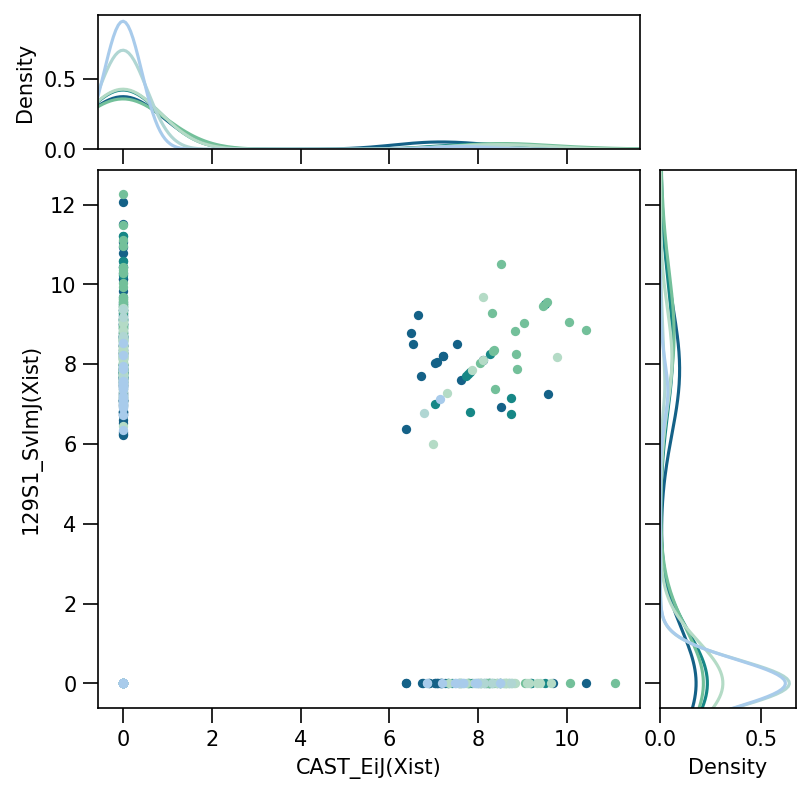

In [119]:
f, ax = plt.subplots(2, 2, figsize=(6,6), gridspec_kw={'height_ratios':[.2,.8],
                                                       'width_ratios':[.8,.2],
                                                       'hspace':.06,
                                                       'wspace':.06})

for i,g in enumerate(list(bc_dict)[::-1]):
    y, X = np.log2([rpkm_cel[bc][ivar,:2] + 1 for bc in bc_dict[g]]).T
    
    sns.scatterplot(x=X, 
                    y=y,
                    s=20,
                    color=coldict[g],
                    linewidth=0, 
                    label=g[-1], 
                    edgecolor='k',
                    legend=False,
                    ax=ax[1,0]
    )
    
    sns.kdeplot(x=X, 
                common_norm=False, 
                color=coldict[g],
                ax=ax[0,0]
    )
    
    sns.kdeplot(y=y, 
                common_norm=False,
                color=coldict[g],
                ax=ax[1,1]
    )
    
ax[0,1].remove()
ax[0,0].set_xlim(ax[1,0].get_xlim())
ax[1,1].set_ylim(ax[1,0].get_ylim())
ax[1,1].set_yticklabels([])
ax[0,0].set_xticklabels([])

#ax[1,0].legend(prop={'size':7}, frameon=False)
# ax[0,0].set_ylim(0,1)
# ax[1,1].set_xlim(0,1)

#ax[0,0].set_yscale('log')

ax[1,0].set_xlabel('CAST_EiJ(Xist)')
ax[1,0].set_ylabel('129S1_SvImJ(Xist)')

___

In [120]:
#Xist threhsold 
thrs = 6 

In [121]:
states = {0:'No X-inactivation',1:'Undertermined',2:'CAST_EiJ inactivated',3:'129S1_SvImJ inactivated'}

states

{0: 'No X-inactivation',
 1: 'Undertermined',
 2: 'CAST_EiJ inactivated',
 3: '129S1_SvImJ inactivated'}

In [127]:
bcs, state = list(), list()
for i,g in enumerate(bc_dict):
    y, X = np.log2([rpkm_cel[bc][ivar,:2] + 1 for bc in bc_dict[g]]).T
    
    idx_act = (X < thrs) & (y < thrs)
    idx_un = (X > thrs) & (y > thrs)
    idx_cas = (X > thrs) & (y < thrs)
    idx_129 = (y > thrs) & (X < thrs)
    
    idx = np.concatenate((idx_act.reshape(idx_act.shape[0],1), idx_un.reshape(idx_un.shape[0],1), 
                          idx_cas.reshape(idx_cas.shape[0],1), idx_129.reshape(idx_129.shape[0],1)), axis=1)
    
    bcs.append(bc_dict[g])
    state.append(idx)
    
bcs, state = np.hstack(bcs), np.vstack(state)

bcs.shape, state.sum(0)

((1536,), array([1135,   44,   94,  263]))

In [128]:
#make sure `bcs` has same order as `anno_sub.index`
d = dict(zip(bcs, range(bcs.size)))
sort_idx = [d[bc] for bc in anno_sub.index]

bcs =  bcs[sort_idx]
state = state[sort_idx]

___

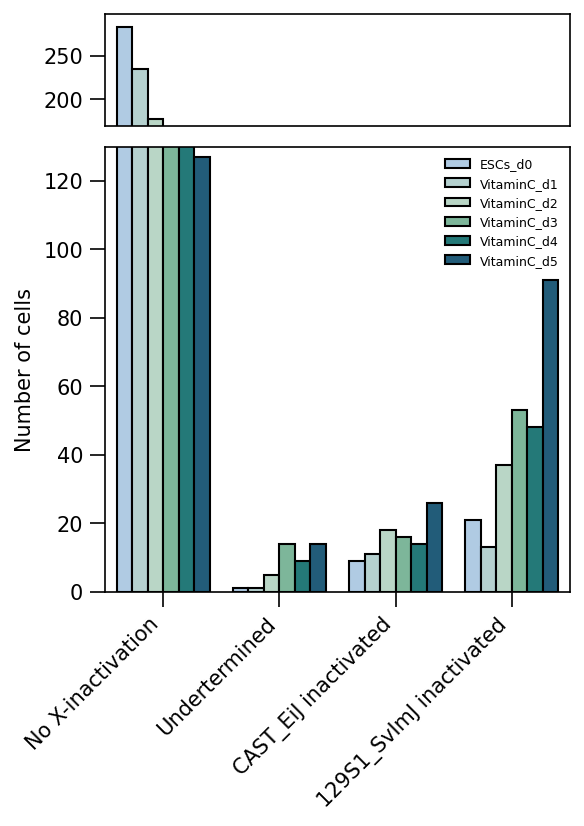

In [133]:
labels = np.repeat([g for g in bc_dict], 4).reshape(len(bc_dict),4)

X = np.zeros((len(bc_dict),4))
for i,g in enumerate(bc_dict):
    idx = np.isin(bcs, bc_dict[g])
    X[i] = state[idx].sum(0)
    
f, ax = plt.subplots(2, 1, figsize=(4,5), gridspec_kw={'height_ratios':[.2,.8],'hspace':.075})

for i in range(ax.size):
    sns.barplot(x=np.hstack(np.tile(list(states.values()), len(bc_dict))), 
                y=np.hstack(X), 
                hue=np.hstack(labels), 
                hue_order=np.unique(labels),
                palette=[coldict[k] for k in np.unique(labels)],
                edgecolor='k',
                estimator='sum',
                errorbar=('ci', 0),
                legend=False if i == 0 else True,
                ax=ax[i]
    )

ax[0].set_xticks([])
ax[0].set_ylim(170)
ax[1].set_ylim(0,130)
ax[1].set_ylabel('Number of cells')
ax[1].set_xticks(range(len(states.values())), states.values(), rotation=45, ha='right')
ax[1].legend(bbox_to_anchor=(1,1), prop={'size':6}, frameon=False)

____

In [200]:
#Xist threhsold 
thrs = 3

In [201]:
X = np.ravel(adata[obs_names,var].layers['CAST_EiJ'])
y = np.ravel(adata[obs_names,var].layers['129S1_SvImJ'])

idx_act = (X < thrs) & (y < thrs)
idx_un = (X > thrs) & (y > thrs)
idx_cas = (X > thrs) & (y < thrs)
idx_129 = (y > thrs) & (X < thrs)

state = np.concatenate((idx_act.reshape(idx_act.shape[0],1), idx_un.reshape(idx_un.shape[0],1), 
                      idx_cas.reshape(idx_cas.shape[0],1), idx_129.reshape(idx_129.shape[0],1)), axis=1)

state.sum(0)

array([919,  44,  83, 229])

In [202]:
X_var = np.c_[X, y]

X_var.shape

(1275, 2)

In [203]:
argsort2d = np.argsort(X_var, axis=1)

argsort2d.shape

(1275, 2)

In [204]:
dam3d = np.array([[fftconvolve(oe_dam_cas[obs][chrom], W, mode='same'),
                   fftconvolve(oe_dam_129[obs][chrom], W, mode='same')] 
                  for obs in obs_names]
)
dam3d.shape

(1275, 2, 1711)

____

In [169]:
import scanpy as sc
import scvelo as scv

In [138]:
X = np.array([counts_cel[obs].sum(1) for obs in anno_sub.index])

X.shape

(1536, 52004)

In [140]:
adata = sc.AnnData(X, obs=anno_sub, var=gtf)

adata

AnnData object with n_obs × n_vars = 1536 × 52004
    obs: 'indexnr', 'barcodenr', 'cellcycle_phase', 'cell_type', '_column', '_row', '_well', 'cellcount', 'construct', 'plate', 'prep', 'treatment', 'limsid', 'dam_counts_cas'
    var: 'gene_id', 'Chromosome', 'Start', 'End', 'Strand', 'tss', 'gene_biotype'

In [141]:
adata.var_names_make_unique()

In [142]:
adata.layers['129S1_SvImJ'] = np.array([counts_cel[obs][:,0] for obs in anno_sub.index])
adata.layers['CAST_EiJ'] = np.array([counts_cel[obs][:,1] for obs in anno_sub.index])

adata

AnnData object with n_obs × n_vars = 1536 × 52004
    obs: 'indexnr', 'barcodenr', 'cellcycle_phase', 'cell_type', '_column', '_row', '_well', 'cellcount', 'construct', 'plate', 'prep', 'treatment', 'limsid', 'dam_counts_cas'
    var: 'gene_id', 'Chromosome', 'Start', 'End', 'Strand', 'tss', 'gene_biotype'
    layers: '129S1_SvImJ', 'CAST_EiJ'

In [143]:
adata.obs['cell_type'] = pd.Categorical(adata.obs['cell_type'])

In [144]:
adata.uns['cell_type_colors'] = np.array(['#a8cbeb', #ESCs_d0
                                          '#b0d6d3',#VitaminC_d1
                                          '#b4dbc6', #VitaminC_d2
                                       '#73c09a', #VitaminC_d3
                                       '#168786', #VitaminC_d4
                                       '#146187'], #VitaminC_d5
                                      dtype=object
)

In [145]:
cell_type_colors = dict(zip(adata.obs['cell_type'].cat.categories,adata.uns['cell_type_colors']))

cell_type_colors

{'ESCs_d0': '#a8cbeb',
 'VitaminC_d1': '#b0d6d3',
 'VitaminC_d2': '#b4dbc6',
 'VitaminC_d3': '#73c09a',
 'VitaminC_d4': '#168786',
 'VitaminC_d5': '#146187'}

____

In [146]:
sc.pp.filter_cells(adata, min_genes=100)

adata

AnnData object with n_obs × n_vars = 1535 × 52004
    obs: 'indexnr', 'barcodenr', 'cellcycle_phase', 'cell_type', '_column', '_row', '_well', 'cellcount', 'construct', 'plate', 'prep', 'treatment', 'limsid', 'dam_counts_cas', 'n_genes'
    var: 'gene_id', 'Chromosome', 'Start', 'End', 'Strand', 'tss', 'gene_biotype'
    uns: 'cell_type_colors'
    layers: '129S1_SvImJ', 'CAST_EiJ'

In [147]:
sc.pp.filter_genes(adata, min_cells=10)

adata

AnnData object with n_obs × n_vars = 1535 × 13313
    obs: 'indexnr', 'barcodenr', 'cellcycle_phase', 'cell_type', '_column', '_row', '_well', 'cellcount', 'construct', 'plate', 'prep', 'treatment', 'limsid', 'dam_counts_cas', 'n_genes'
    var: 'gene_id', 'Chromosome', 'Start', 'End', 'Strand', 'tss', 'gene_biotype', 'n_cells'
    uns: 'cell_type_colors'
    layers: '129S1_SvImJ', 'CAST_EiJ'

In [148]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')  
adata.var['ERCC'] = adata.var_names.str.startswith('ERCC') 
adata.var['Gm'] = adata.var_names.str.startswith('Gm') 
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ERCC','Gm'], percent_top=None, log1p=False, inplace=True)

In [149]:
adata = adata[adata.obs.pct_counts_mt < 10,]

adata

View of AnnData object with n_obs × n_vars = 1441 × 13313
    obs: 'indexnr', 'barcodenr', 'cellcycle_phase', 'cell_type', '_column', '_row', '_well', 'cellcount', 'construct', 'plate', 'prep', 'treatment', 'limsid', 'dam_counts_cas', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ERCC', 'pct_counts_ERCC', 'total_counts_Gm', 'pct_counts_Gm'
    var: 'gene_id', 'Chromosome', 'Start', 'End', 'Strand', 'tss', 'gene_biotype', 'n_cells', 'mt', 'ERCC', 'Gm', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'cell_type_colors'
    layers: '129S1_SvImJ', 'CAST_EiJ'

In [150]:
adata = adata[adata.obs.pct_counts_ERCC < 3,]

adata

View of AnnData object with n_obs × n_vars = 1441 × 13313
    obs: 'indexnr', 'barcodenr', 'cellcycle_phase', 'cell_type', '_column', '_row', '_well', 'cellcount', 'construct', 'plate', 'prep', 'treatment', 'limsid', 'dam_counts_cas', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ERCC', 'pct_counts_ERCC', 'total_counts_Gm', 'pct_counts_Gm'
    var: 'gene_id', 'Chromosome', 'Start', 'End', 'Strand', 'tss', 'gene_biotype', 'n_cells', 'mt', 'ERCC', 'Gm', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'cell_type_colors'
    layers: '129S1_SvImJ', 'CAST_EiJ'

In [151]:
adata = adata[adata.obs.pct_counts_Gm < 5,]

adata

View of AnnData object with n_obs × n_vars = 1427 × 13313
    obs: 'indexnr', 'barcodenr', 'cellcycle_phase', 'cell_type', '_column', '_row', '_well', 'cellcount', 'construct', 'plate', 'prep', 'treatment', 'limsid', 'dam_counts_cas', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ERCC', 'pct_counts_ERCC', 'total_counts_Gm', 'pct_counts_Gm'
    var: 'gene_id', 'Chromosome', 'Start', 'End', 'Strand', 'tss', 'gene_biotype', 'n_cells', 'mt', 'ERCC', 'Gm', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'cell_type_colors'
    layers: '129S1_SvImJ', 'CAST_EiJ'

In [152]:
adata = adata[:,~adata.var_names.str.startswith('ERCC')]

adata

View of AnnData object with n_obs × n_vars = 1427 × 13302
    obs: 'indexnr', 'barcodenr', 'cellcycle_phase', 'cell_type', '_column', '_row', '_well', 'cellcount', 'construct', 'plate', 'prep', 'treatment', 'limsid', 'dam_counts_cas', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ERCC', 'pct_counts_ERCC', 'total_counts_Gm', 'pct_counts_Gm'
    var: 'gene_id', 'Chromosome', 'Start', 'End', 'Strand', 'tss', 'gene_biotype', 'n_cells', 'mt', 'ERCC', 'Gm', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'cell_type_colors'
    layers: '129S1_SvImJ', 'CAST_EiJ'

In [153]:
sc.pp.normalize_total(adata, target_sum=1e4)

/opt/miniconda3/envs/scanalysis/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [154]:
sc.pp.log1p(adata)

In [155]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='seurat', batch_key='treatment')

adata

AnnData object with n_obs × n_vars = 1427 × 13302
    obs: 'indexnr', 'barcodenr', 'cellcycle_phase', 'cell_type', '_column', '_row', '_well', 'cellcount', 'construct', 'plate', 'prep', 'treatment', 'limsid', 'dam_counts_cas', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ERCC', 'pct_counts_ERCC', 'total_counts_Gm', 'pct_counts_Gm'
    var: 'gene_id', 'Chromosome', 'Start', 'End', 'Strand', 'tss', 'gene_biotype', 'n_cells', 'mt', 'ERCC', 'Gm', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'cell_type_colors', 'log1p', 'hvg'
    layers: '129S1_SvImJ', 'CAST_EiJ'

In [156]:
adata.raw = adata

In [157]:
adata = adata[:, adata.var.highly_variable]

adata

View of AnnData object with n_obs × n_vars = 1427 × 2000
    obs: 'indexnr', 'barcodenr', 'cellcycle_phase', 'cell_type', '_column', '_row', '_well', 'cellcount', 'construct', 'plate', 'prep', 'treatment', 'limsid', 'dam_counts_cas', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ERCC', 'pct_counts_ERCC', 'total_counts_Gm', 'pct_counts_Gm'
    var: 'gene_id', 'Chromosome', 'Start', 'End', 'Strand', 'tss', 'gene_biotype', 'n_cells', 'mt', 'ERCC', 'Gm', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'cell_type_colors', 'log1p', 'hvg'
    layers: '129S1_SvImJ', 'CAST_EiJ'

In [158]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

In [159]:
sc.pp.scale(adata, max_value=10)

In [160]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=100, random_state=0)

adata

AnnData object with n_obs × n_vars = 1427 × 2000
    obs: 'indexnr', 'barcodenr', 'cellcycle_phase', 'cell_type', '_column', '_row', '_well', 'cellcount', 'construct', 'plate', 'prep', 'treatment', 'limsid', 'dam_counts_cas', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ERCC', 'pct_counts_ERCC', 'total_counts_Gm', 'pct_counts_Gm'
    var: 'gene_id', 'Chromosome', 'Start', 'End', 'Strand', 'tss', 'gene_biotype', 'n_cells', 'mt', 'ERCC', 'Gm', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'cell_type_colors', 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: '129S1_SvImJ', 'CAST_EiJ'

/opt/miniconda3/envs/scanalysis/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


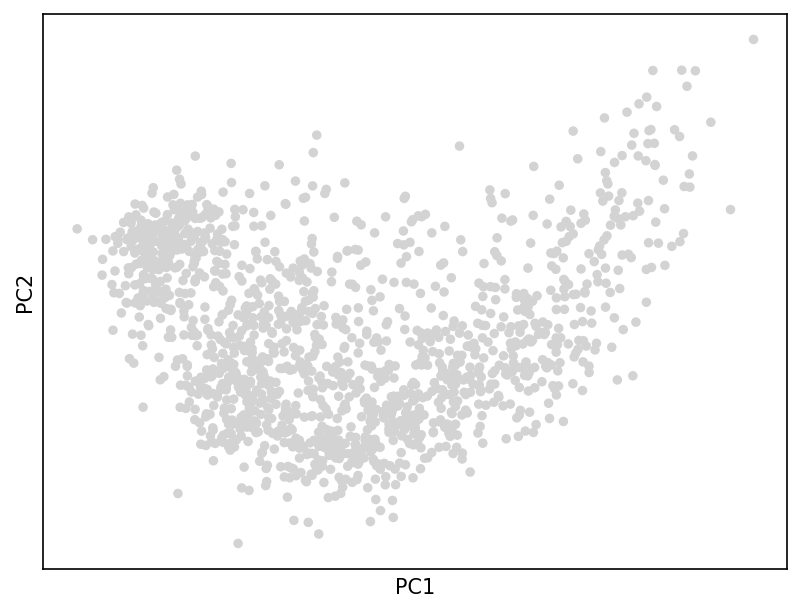

In [161]:
sc.pl.pca(adata)

In [162]:
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=20, random_state=0, use_rep='X_pca')

In [163]:
sc.tl.leiden(adata, resolution=.75, random_state=0)

In [164]:
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False) 
sc.tl.umap(adata, min_dist=.3, random_state=0, init_pos='paga')

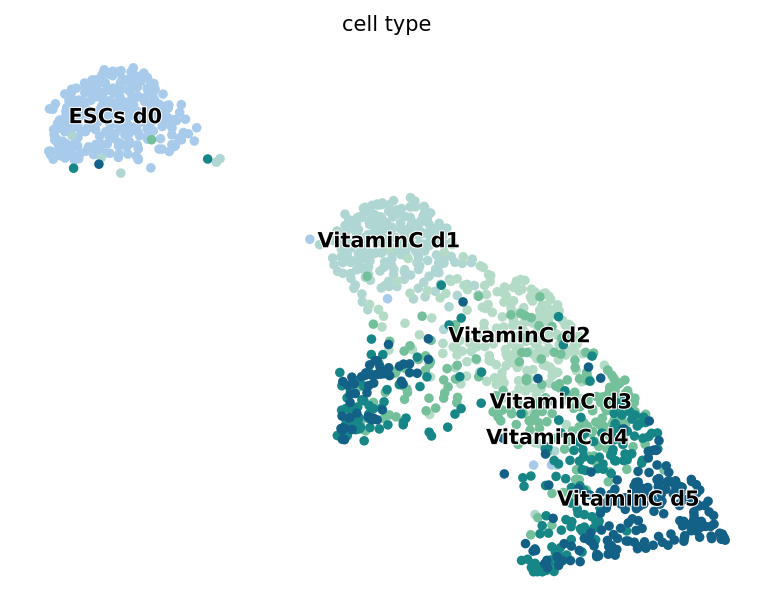

In [170]:
scv.pl.umap(adata, 
            color=['cell_type'], )

### R intermezzo: 
### Trajectory inference with `Monocle3`

In [171]:
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

In [172]:
adata_sce = sc.AnnData(X=adata.X, obs=adata.obs[['limsid','cell_type','leiden']], 
                       var=pd.DataFrame(index=adata.var.index))
#adata_sce.obs['cell_type'] = np.ravel(adata_sce.obs['cell_type'])
adata_sce.obsm = adata.obsm

adata_sce

AnnData object with n_obs × n_vars = 1427 × 2000
    obs: 'limsid', 'cell_type', 'leiden'
    obsm: 'X_pca', 'X_umap'

In [173]:
%%R
set.seed(0)

In [174]:
%%R -i adata_sce
adata_sce

class: SingleCellExperiment 
dim: 2000 1427 
metadata(0):
assays(1): X
rownames(2000): H19 Klf6 ... AC116589.11 AC124772.5
rowData names(0):
colnames(1427): VAN10206.index27.002 VAN10206.index27.003 ...
  VAN10206.index36.381 VAN10206.index36.383
colData names(3): limsid cell_type leiden
reducedDimNames(2): PCA UMAP
mainExpName: NULL
altExpNames(0):


In [175]:
%%R
library(monocle3)


Attaching package: ‘monocle3’

The following objects are masked from ‘package:Biobase’:

    exprs, fData, fData<-, pData, pData<-



In [176]:
%%R
adata_sce_sub <- adata_sce[ ,!adata_sce@colData$leiden %in% c('5')]

adata_sce_sub

class: SingleCellExperiment 
dim: 2000 1275 
metadata(0):
assays(1): X
rownames(2000): H19 Klf6 ... AC116589.11 AC124772.5
rowData names(0):
colnames(1275): VAN10206.index27.002 VAN10206.index27.003 ...
  VAN10206.index36.380 VAN10206.index36.383
colData names(3): limsid cell_type leiden
reducedDimNames(2): PCA UMAP
mainExpName: NULL
altExpNames(0):


In [177]:
%%R
gene_annotation <- as.data.frame(rownames(adata_sce_sub))
colnames(gene_annotation) <- "gene_short_name"

In [178]:
%%R
#create `monocle` object
cds <- new_cell_data_set(adata_sce_sub@assays@data$X, 
                         cell_metadata = adata_sce_sub@colData, 
                         gene_metadata = gene_annotation
)
cds

class: cell_data_set 
dim: 2000 1275 
metadata(1): cds_version
assays(1): counts
rownames: NULL
rowData names(1): gene_short_name
colnames(1275): VAN10206.index27.002 VAN10206.index27.003 ...
  VAN10206.index36.380 VAN10206.index36.383
colData names(4): limsid cell_type leiden Size_Factor
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


In addition: Warning message:
In log(cell_total) : NaNs produced


In [179]:
%%R
recreate.partition <- c(rep(1, length(cds@colData@rownames)))
names(recreate.partition) <- cds@colData@rownames
recreate.partition <- as.factor(recreate.partition)
cds@clusters@listData[["UMAP"]][["partitions"]] <- recreate.partition

In [180]:
%%R
# assign seurat cluster info
list_cluster <- adata_sce_sub@colData$leiden
cds@clusters@listData[["UMAP"]][["clusters"]] <- list_cluster

In [181]:
%%R 
# assign cell type info
cds@colData[["leiden"]] <- adata_sce_sub@colData$leiden

In [182]:
%%R 
# assign dim reduction coordinates
cds@int_colData$reducedDims@listData[['UMAP']] <- reducedDim(adata_sce_sub, "UMAP")

In [183]:
%%R
#compute pseudotime
cds <- learn_graph(cds)

  |======================================================================| 100%


'as(<dsCMatrix>, "dgCMatrix")' is deprecated.
Use 'as(., "generalMatrix")' instead.
See help("Deprecated") and help("Matrix-deprecated").
In addition: Warning message:
In igraph::graph.dfs(stree_ori, root = root_cell, neimode = "all",  :
  Argument `neimode' is deprecated; use `mode' instead


In addition: Warning message:
`select_()` was deprecated in dplyr 0.7.0.
ℹ Please use `select()` instead.
ℹ The deprecated feature was likely used in the monocle3 package.
  Please report the issue to the authors.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 


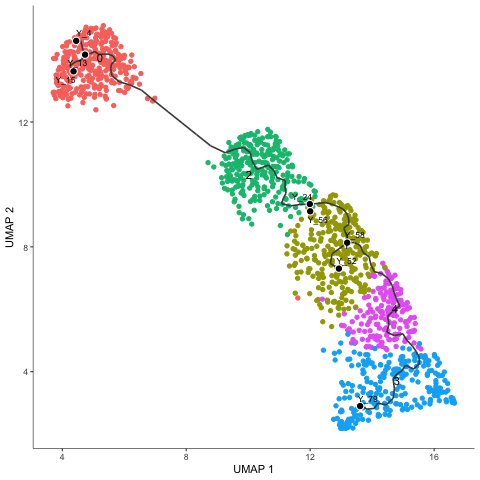

In [184]:
%%R
#plot seurat clustered cells in monocle object
plot_cells(cds, color_cells_by = "leiden", cell_size = 1.5, 
           group_label_size = 4, reduction_method = 'UMAP', label_principal_points = TRUE)

In [185]:
%%R
cds <- order_cells(cds, root_pr_nodes = 'Y_4')

Cells aren't colored in a way that allows them to be grouped.


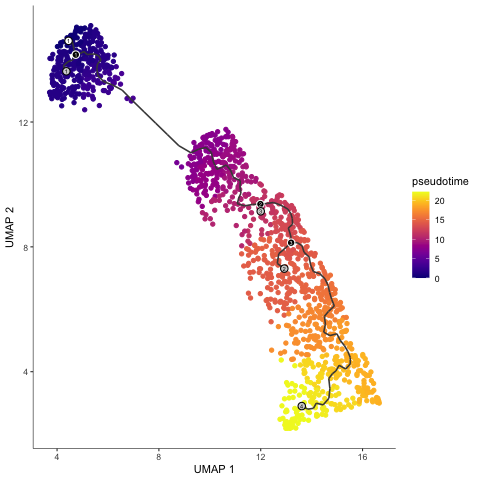

In [186]:
%%R
plot_cells(cds, color_cells_by = "pseudotime", 
           cell_size = 1.5, group_label_size = 4, reduction_method = 'UMAP')

In [187]:
%%R
pt <- as.data.frame(cds@principal_graph_aux@listData[["UMAP"]][["pseudotime"]])
colnames(pt) <- c('pseudotime')

In [188]:
%%R -o pt
head(pt)

                     pseudotime
VAN10206.index27.002   3.555317
VAN10206.index27.003   1.406080
VAN10206.index27.005   1.346245
VAN10206.index27.006   1.433407
VAN10206.index27.007   2.849837
VAN10206.index27.008   1.297321


____
                                                   ~~~ End intermezzo ~~~
____                                

In [189]:
adata.obs['monocle_pseudotime'] = np.nan
adata.obs.loc[pt.index,'monocle_pseudotime'] = pt['pseudotime'].values

<Axes: title={'center': 'monocle_pseudotime'}, xlabel='UMAP1', ylabel='UMAP2'>

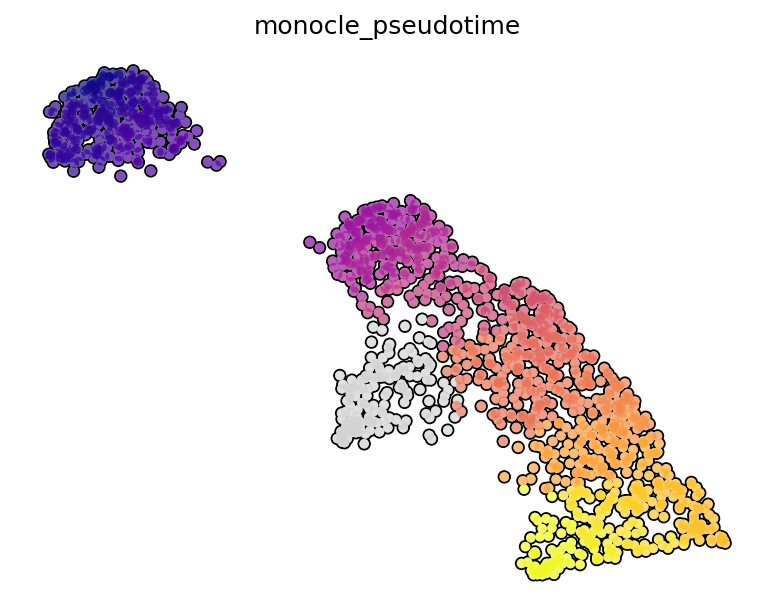

In [191]:
sc.pl.umap(adata, 
           color='monocle_pseudotime', 
           outline_color=('black','white'), 
           outline_width=(.2,.0), cmap='plasma', 
           add_outline=True, 
           colorbar_loc=None,
           frameon=False,
           show=False
)

___

In [192]:
obs_names = adata.obs[~adata.obs['monocle_pseudotime'].isna()].sort_values('monocle_pseudotime').index

obs_names

Index(['VAN10206.index27.280', 'VAN10206.index27.018', 'VAN10206.index27.046',
       'VAN10206.index27.054', 'VAN10206.index27.132', 'VAN10206.index27.139',
       'VAN10206.index27.146', 'VAN10206.index27.227', 'VAN10206.index27.123',
       'VAN10206.index27.297',
       ...
       'VAN10206.index36.352', 'VAN10206.index36.380', 'VAN10206.index34.128',
       'VAN10206.index34.046', 'VAN10206.index36.044', 'VAN10206.index36.274',
       'VAN10206.index36.244', 'VAN10206.index34.118', 'VAN10206.index36.171',
       'VAN10206.index36.159'],
      dtype='object', length=1275)

In [193]:
sc.pp.normalize_total(adata, layer='129S1_SvImJ', target_sum=1e4)
sc.pp.normalize_total(adata, layer='CAST_EiJ', target_sum=1e4)

In [194]:
sc.pp.log1p(adata, layer='129S1_SvImJ')
sc.pp.log1p(adata, layer='CAST_EiJ')

In [195]:
adata.layers['spliced'] = adata.X
adata.layers['unspliced'] = adata.X

In [196]:
scv.pp.moments(adata, 
               n_pcs=30, 
               n_neighbors=30, 
               use_rep='X_pca_harmony'
)

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


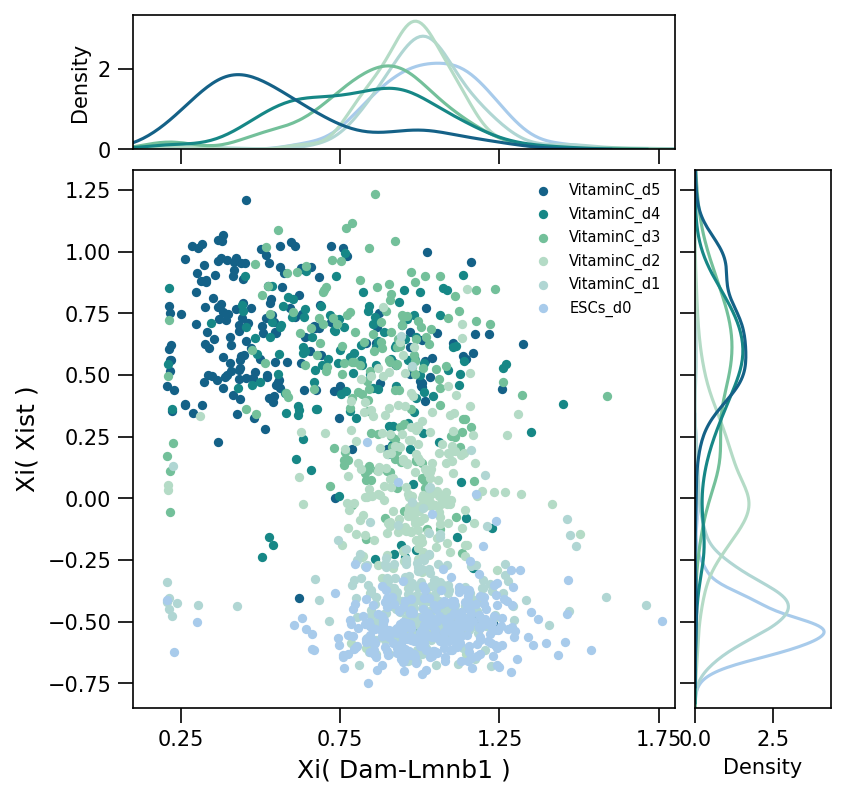

In [209]:
y2d = np.take_along_axis(dam3d, argsort2d[:,1].reshape(obs_names.size,1,-1), axis=1).reshape(obs_names.size,dam3d.shape[2])
X = (y2d[:,lb1_k27_idx].mean(1))
y = np.ravel(adata[obs_names,var].layers['Ms'].toarray())

f, ax = plt.subplots(2, 2, figsize=(6,6), gridspec_kw={'height_ratios':[.2,.8],
                                                       'width_ratios':[.8,.2],
                                                       'hspace':.06,
                                                       'wspace':.06}, dpi=150)

for cell_type in np.unique(anno_sub.loc[obs_names,'cell_type'])[::-1]:
        idx = anno_sub.loc[obs_names,'cell_type'] == cell_type
        sns.scatterplot(x=X[idx], 
                        y=y[idx],
                        s=20, 
                        linewidth=0, 
                        edgecolor='k',
                        color=cell_type_colors[cell_type],
                        label=cell_type,
                        ax=ax[1,0]
        )
sns.kdeplot(x=X, 
            hue=anno_sub.loc[obs_names,'cell_type'], 
            hue_order=np.unique(anno_sub['cell_type'])[::-1], 
            palette=[cell_type_colors[cell_type] for cell_type in np.unique(anno_sub['cell_type'])[::-1]],
            common_norm=False,
            ax=ax[0,0]
)

sns.kdeplot(y=y, 
            hue=anno_sub.loc[obs_names,'cell_type'], 
            hue_order=np.unique(anno_sub['cell_type'])[::-1],
            palette=[cell_type_colors[cell_type] for cell_type in np.unique(anno_sub['cell_type'])[::-1]],
            common_norm=False,
            ax=ax[1,1]
)

ax[1,0].set_xticks(np.arange(.25,1.76,.5))
ax[0,0].set_xticks(np.arange(.25,1.76,.5))

ax[1,0].set_xlim(right=1.8)
ax[1,0].set_xlabel('Xi( Dam-Lmnb1 )', fontsize=12)
ax[1,0].set_ylabel('Xi( Xist )', fontsize=12)
ax[1,0].legend(prop={'size':7}, frameon=False)

ax[0,1].remove()
ax[0,0].set_xlim(ax[1,0].get_xlim())
ax[1,1].set_ylim(ax[1,0].get_ylim())
ax[1,1].set_yticklabels([])
ax[0,0].set_xticklabels([])
ax[0,0].get_legend().remove()
ax[1,1].get_legend().remove()

___

Text(0, 0.5, 'Dam-LMNB1')

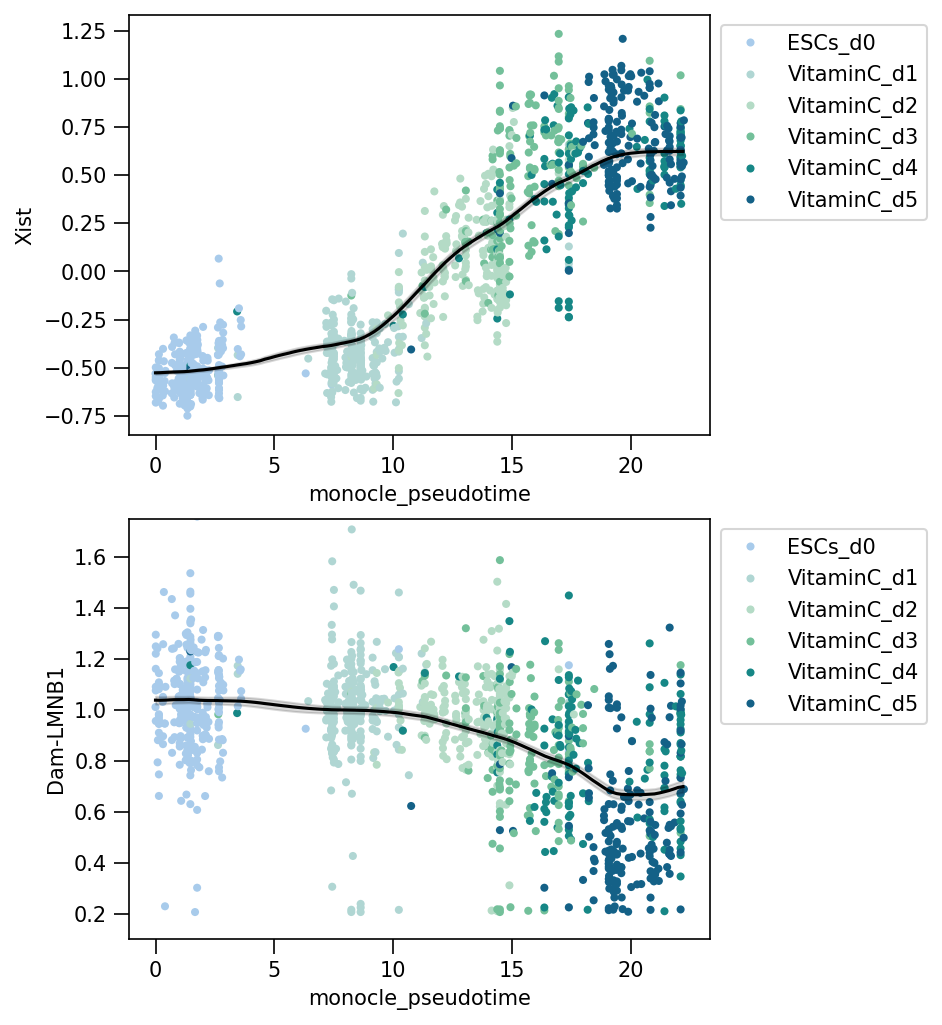

In [210]:
X = adata.obs.loc[obs_names,'monocle_pseudotime']

f, ax = plt.subplots(2, 1, figsize=(5,8), dpi=150)

#Xist
y = np.ravel(adata[obs_names,var].layers['Ms'].toarray())
#y = np.ravel(np.take_along_axis(X_var, argsort2d[:,1].reshape(obs_names.size,-1), axis=1))

sns.scatterplot(x=X, 
                y=y, 
                hue=adata.obs.loc[obs_names,'cell_type'], 
                hue_order=adata.obs['cell_type'].cat.categories,
                palette=adata.uns['cell_type_colors'],
                lw=0, 
                s=15,
                ax=ax[0]
)

xhat, yhat, yhat_sem = sccu.RNR(X=X, 
                                y=y, 
                                _RADIUS=2, 
                                step=.2
)
ax[0].plot(xhat, 
           yhat, 
           color='k'
)
ax[0].fill_between(xhat, 
                   yhat-yhat_sem, 
                   yhat+yhat_sem, 
                   color='k', 
                   alpha=.15
)

#Dam-LMNB1
y2d = np.take_along_axis(dam3d, argsort2d[:,1].reshape(obs_names.size,1,-1), axis=1).reshape(obs_names.size,dam3d.shape[2])
y = (y2d[:,lb1_k27_idx].mean(1))

sns.scatterplot(x=X, 
                y=y, 
                hue=adata.obs.loc[obs_names,'cell_type'], 
                hue_order=adata.obs['cell_type'].cat.categories,
                palette=adata.uns['cell_type_colors'],
                lw=0, 
                s=15,
                ax=ax[1]
)

xhat, yhat, yhat_sem = sccu.RNR(X=X, 
                                y=y, 
                                _RADIUS=2, 
                                step=.2
)
ax[1].plot(xhat, 
           yhat, 
           color='k'
)
ax[1].fill_between(xhat, 
                   yhat-yhat_sem, 
                   yhat+yhat_sem, 
                   color='k', 
                   alpha=.15
)

ax[1].set_ylim(top=1.75)
ax[0].legend(bbox_to_anchor=(1,1))
ax[1].legend(bbox_to_anchor=(1,1))

ax[0].set_ylabel(var)
ax[1].set_ylabel('Dam-LMNB1')

___

### All modalities combined

In [211]:
df_ub_damk27 = pd.read_csv('/Users/prullens/Documents/projects/DamnChIC/ub_damk27_cell_type_mean_ci.tsv', sep='\t', index_col=0)
df_k27_damlb1 = pd.read_csv('/Users/prullens/Documents/projects/DamnChIC/k27_damlb1_cell_type_mean_ci.tsv', sep='\t', index_col=0)
df_xist_damlb1 = pd.read_csv('/Users/prullens/Documents/projects/DamnChIC/experiments/VAN10206/VAN10206_xist_damlb1_cell_type_mean_ci.tsv', sep='\t', index_col=0)

In [212]:
#Ub
ub_mean = df_ub_damk27['ub_mean']
ub_ci_max = df_ub_damk27['ub_mean'] + df_ub_damk27['ub_ci95']
ub_ci_min = df_ub_damk27['ub_mean'] - df_ub_damk27['ub_ci95']
ub_mean_scaled = (ub_mean - ub_ci_min.min()) /  (ub_ci_max.max() - ub_ci_min.min())
ub_ci_min_scaled = (ub_ci_min - ub_ci_min.min()) / (ub_ci_max.max() - ub_ci_min.min())
ub_ci95_scaled = ub_mean_scaled - ub_ci_min_scaled

#Damk27
damk27_mean = df_ub_damk27['damk27_mean']
damk27_ci_max = df_ub_damk27['damk27_mean'] + df_ub_damk27['damk27_ci95']
damk27_ci_min = df_ub_damk27['damk27_mean'] - df_ub_damk27['damk27_ci95']
damk27_mean_scaled = (damk27_mean - damk27_ci_min.min()) /  (damk27_ci_max.max() - damk27_ci_min.min())
damk27_ci_min_scaled = (damk27_ci_min - damk27_ci_min.min()) / (damk27_ci_max.max() - damk27_ci_min.min())
damk27_ci95_scaled = damk27_mean_scaled - damk27_ci_min_scaled

#Xist
xist_mean = df_xist_damlb1['xist_mean']
xist_ci_max = df_xist_damlb1['xist_mean'] + df_xist_damlb1['xist_ci95']
xist_ci_min = df_xist_damlb1['xist_mean'] - df_xist_damlb1['xist_ci95']
xist_mean_scaled = (xist_mean - xist_ci_min.min()) /  (xist_ci_max.max() - xist_ci_min.min())
xist_ci_min_scaled = (xist_ci_min - xist_ci_min.min()) / (xist_ci_max.max() - xist_ci_min.min())
xist_ci95_scaled = xist_mean_scaled - xist_ci_min_scaled

#Damlb1
damlb1_mean = df_xist_damlb1['damlb1_mean']
damlb1_ci_max = df_xist_damlb1['damlb1_mean'] + df_xist_damlb1['damlb1_ci95']
damlb1_ci_min = df_xist_damlb1['damlb1_mean'] - df_xist_damlb1['damlb1_ci95']
damlb1_mean_scaled = (damlb1_mean - damlb1_ci_min.min()) /  (damlb1_ci_max.max() - damlb1_ci_min.min())
damlb1_ci_min_scaled = (damlb1_ci_min - damlb1_ci_min.min()) / (damlb1_ci_max.max() - damlb1_ci_min.min())
damlb1_ci95_scaled = damlb1_mean_scaled - damlb1_ci_min_scaled

#Damlb1
damlb1_mean = df_k27_damlb1['damlb1_mean']
damlb1_ci_max = df_k27_damlb1['damlb1_mean'] + df_k27_damlb1['damlb1_ci95']
damlb1_ci_min = df_k27_damlb1['damlb1_mean'] - df_k27_damlb1['damlb1_ci95']
damlb1_mean_scaled = (damlb1_mean - damlb1_ci_min.min()) /  (damlb1_ci_max.max() - damlb1_ci_min.min())
damlb1_ci_min_scaled = (damlb1_ci_min - damlb1_ci_min.min()) / (damlb1_ci_max.max() - damlb1_ci_min.min())
damlb1_ci95_scaled = damlb1_mean_scaled - damlb1_ci_min_scaled

#k27
k27_mean = df_k27_damlb1['k27_mean']
k27_ci_max = df_k27_damlb1['k27_mean'] + df_k27_damlb1['k27_ci95']
k27_ci_min = df_k27_damlb1['k27_mean'] - df_k27_damlb1['k27_ci95']
k27_mean_scaled = (k27_mean - k27_ci_min.min()) /  (k27_ci_max.max() - k27_ci_min.min())
k27_ci_min_scaled = (k27_ci_min - k27_ci_min.min()) / (k27_ci_max.max() - k27_ci_min.min())
k27_ci95_scaled = k27_mean_scaled - k27_ci_min_scaled

Text(0.5, 0, 'XCI')

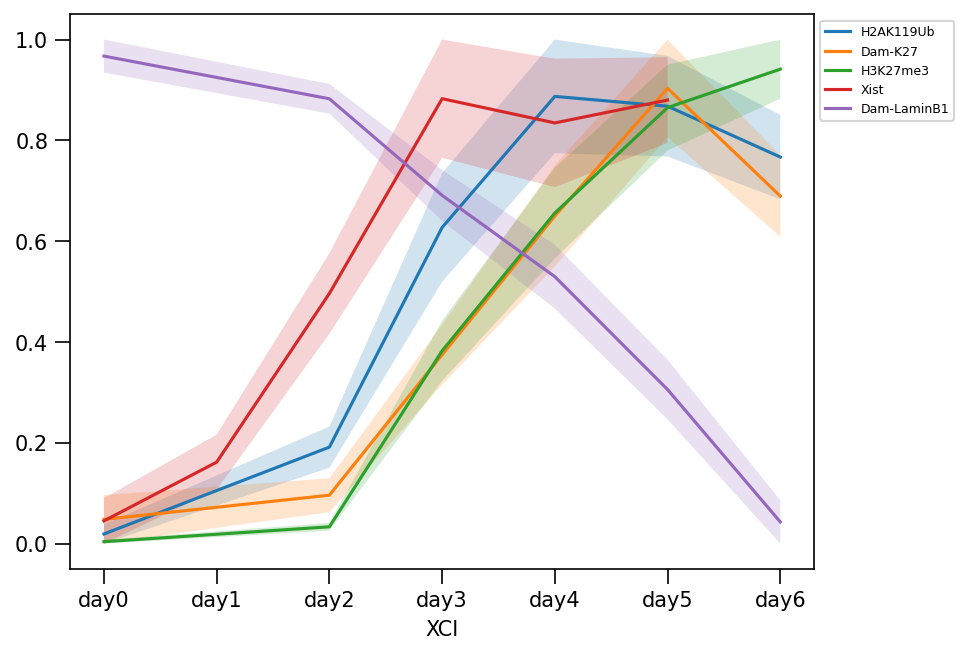

In [214]:
f, ax = plt.subplots()

ax.plot(ub_mean.index.str[-1].astype(int), 
        ub_mean_scaled, 
        label='H2AK119Ub')
ax.fill_between(ub_mean.index.str[-1].astype(int), 
                ub_mean_scaled - ub_ci95_scaled, 
                ub_mean_scaled + ub_ci95_scaled, 
                alpha=.2
)

ax.plot(damk27_mean.index.str[-1].astype(int), 
        damk27_mean_scaled, 
        label='Dam-K27')
ax.fill_between(damk27_mean.index.str[-1].astype(int), 
                damk27_mean_scaled - damk27_ci95_scaled, 
                damk27_mean_scaled + damk27_ci95_scaled, 
                alpha=.2
)

ax.plot(damk27_mean.index.str[-1].astype(int), 
        k27_mean_scaled, 
        label='H3K27me3')
ax.fill_between(damk27_mean.index.str[-1].astype(int), 
                k27_mean_scaled - k27_ci95_scaled, 
                k27_mean_scaled + k27_ci95_scaled, 
                alpha=.2
)
ax.plot(xist_mean.index.str[-1].astype(int), 
        xist_mean_scaled, 
        label='Xist')
ax.fill_between(xist_mean.index.str[-1].astype(int), 
                xist_mean_scaled - xist_ci95_scaled, 
                xist_mean_scaled + xist_ci95_scaled, 
                alpha=.2
)

#ax_r = ax.twinx()
ax.plot(ub_mean.index.str[-1].astype(int), 
        damlb1_mean_scaled, 
        label='Dam-LaminB1')
ax.fill_between(ub_mean.index.str[-1].astype(int), 
                damlb1_mean_scaled - damlb1_ci95_scaled, 
                damlb1_mean_scaled + damlb1_ci95_scaled, 
                alpha=.2
)
#ax_r.invert_yaxis

ax.legend(prop={'size':6}, bbox_to_anchor=(1,1))

ax.set_xticks(range(7),[f"day{i}" for i in range(7)])
ax.set_xlabel('XCI')